In [ ]:
# mounting the google drive where the data csv files downloaded
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os,gc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,roc_curve,auc,confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import time
plt.style.use('seaborn-whitegrid')
import warnings
warnings.simplefilter("ignore")
colors = [x['color'] for x in plt.rcParams['axes.prop_cycle']]
import itertools

In [ ]:
'''
tran_df = pd.read_csv('/gdrive/My Drive/AIML/Project/train_transaction.csv')
id_df = pd.read_csv('/gdrive/My Drive/AIML/Project/train_identity.csv')
train_data = tran_df.merge(id_df, how='left', left_index=True, right_index=True)

test_tran_df = pd.read_csv('/gdrive/My Drive/AIML/Project/test_transaction.csv')
test_id_df = pd.read_csv('/gdrive/My Drive/AIML/Project/test_identity.csv')
test_data = test_tran_df.merge(test_id_df, how='left', left_index=True, right_index=True)

train_data.to_csv("/gdrive/My Drive/AIML/Project/train_combined.csv", index=False)
test_data.to_csv("/gdrive/My Drive/AIML/Project/test_combined.csv", index=False)

print(train_data.shape)
print(test_data.shape)
'''

'\ntran_df = pd.read_csv(\'/gdrive/My Drive/AIML/Project/train_transaction.csv\')\nid_df = pd.read_csv(\'/gdrive/My Drive/AIML/Project/train_identity.csv\')\ntrain_data = tran_df.merge(id_df, how=\'left\', left_index=True, right_index=True)\n\ntest_tran_df = pd.read_csv(\'/gdrive/My Drive/AIML/Project/test_transaction.csv\')\ntest_id_df = pd.read_csv(\'/gdrive/My Drive/AIML/Project/test_identity.csv\')\ntest_data = test_tran_df.merge(test_id_df, how=\'left\', left_index=True, right_index=True)\n\ntrain_data.to_csv("/gdrive/My Drive/AIML/Project/train_combined.csv", index=False)\ntest_data.to_csv("/gdrive/My Drive/AIML/Project/test_combined.csv", index=False)\n\nprint(train_data.shape)\nprint(test_data.shape)\n'

In [ ]:
train_data = pd.read_csv("/gdrive/My Drive/AIML/Project/train_combined.csv")
test_data = pd.read_csv("/gdrive/My Drive/AIML/Project/test_combined.csv")

In [ ]:
# Funcation to calculate the columns with the null data more than threshold
def top_missing_cols(df,n=10,thresh=80):  
    dff = (df.isnull().sum()/df.shape[0])*100
    dff = dff.reset_index()
    dff.columns = ['col','missing_percent']
    dff = dff.sort_values(by=['missing_percent'],ascending=False).reset_index(drop=True)
    print(f'There are {df.isnull().any().sum()} columns in this dataset with missing values.')
    print(f'There are {dff[dff["missing_percent"] > thresh].shape[0]} columns with missing percent values than {thresh}%')
    if n:
        return dff.head(n)
    else:
        return dff

In [ ]:
df_missing = top_missing_cols(train_data,n=None,thresh=50)
# Taking all column with missing percen > 50
missing_cols = df_missing['col']


There are 415 columns in this dataset with missing values.
There are 215 columns with missing percent values than 50%


In [ ]:
# we will take all columns and group them based on missing percentage
nan_dict = {}
for col in missing_cols:
    count = train_data[col].isnull().sum()
    try:
        nan_dict[count].extend(col)
    except:
        nan_dict[count] = [col]
        
for k,v in nan_dict.items():
    print(f'#####' * 4)
    print(f'NAN count = {k} percent: {(int(k)/train_data.shape[0])*100} %')
    print(v)

####################
NAN count = 585793 percent: 99.19615944728554 %
['id_24']
####################
NAN count = 585408 percent: 99.13096487960172 %
['id_25']
####################
NAN count = 585385 percent: 99.12707013919464 %
['id_07', 'i', 'd', '_', '0', '8']
####################
NAN count = 585381 percent: 99.12639279303687 %
['id_21']
####################
NAN count = 585377 percent: 99.12571544687913 %
['id_26']
####################
NAN count = 585371 percent: 99.1246994276425 %
['id_27', 'i', 'd', '_', '2', '3', 'i', 'd', '_', '2', '2']
####################
NAN count = 552913 percent: 93.62837403054831 %
['dist2']
####################
NAN count = 551623 percent: 93.40992989467267 %
['D7']
####################
NAN count = 545427 percent: 92.36072069631184 %
['id_18']
####################
NAN count = 528588 percent: 89.50926270870728 %
['D13']
####################
NAN count = 528353 percent: 89.46946862193924 %
['D14']
####################
NAN count = 525823 percent: 89.041047177159

In [ ]:
def corelation_analysis(cols,title='Coorelation Analysis',size=(12,12)):
    cols = sorted(cols)
    fig,axes = plt.subplots(1,1,figsize=size)
    df_corr = train_data[cols].corr()
    sns.heatmap(df_corr,annot=True,cmap='RdBu_r')
    axes.title.set_text(title)
    plt.show()

In [ ]:
# finding the column that has more unique values in the group of attributes
def reduce_groups(grps):
    use = []
    for col in grps:
        max_unique = 0
        max_index = 0
        for i,c in enumerate(col):
            n = train_data[c].nunique()
            if n > max_unique:
                max_unique = n
                max_index = i
        use.append(col[max_index])
    return use

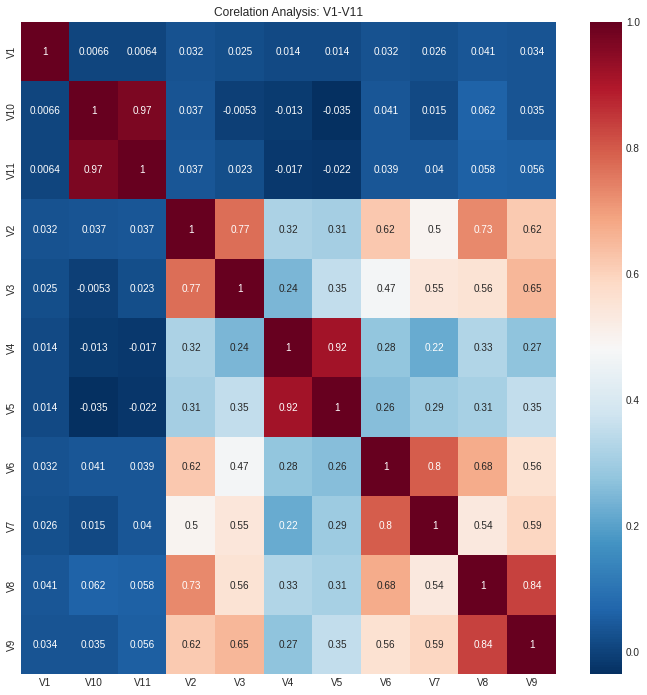

In [ ]:
# Let's see the corelation for one of the groups in V cols
cols = ['V3', 'V9', 'V5', 'V11', 'V10', 'V8', 'V7', 'V6', 'V4', 'V2', 'V1']
corelation_analysis(cols,title='Corelation Analysis: V1-V11')

In [ ]:
pairs = [['V1'],['V2','V3'],['V4','V5'],['V6','V7'],['V8','V9'],['V10','V11']]
return_list = reduce_groups(pairs)
keep_cols = []
keep_cols.extend(return_list)
keep_cols

['V1', 'V3', 'V4', 'V6', 'V8', 'V11']

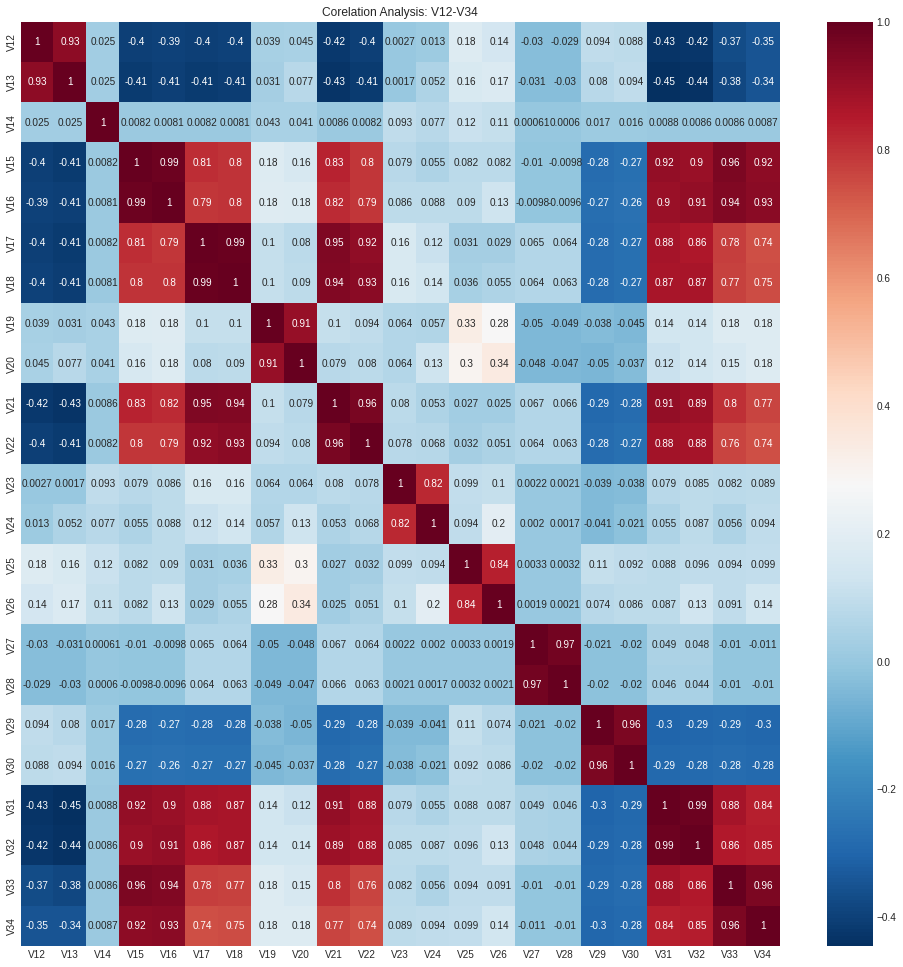

In [ ]:
cols = ['V21', 'V22', 'V23', 'V34', 'V33', 'V32','V31', 'V30', 'V29', 'V28', 
         'V27', 'V25', 'V24', 'V26', 'V16', 'V15', 
        'V20', 'V14', 'V19', 'V18', 'V17', 'V12', 'V13']

corelation_analysis(cols,title='Corelation Analysis: V12-V34',size=(17,17))

In [ ]:
pairs = [['V12','V13'],['V14'],['V15','V16','V17','V18','V21','V22','V31','V32','V33','V34'],['V19','V20'],
         ['V23','V24'],['V25','V26'],['V27','V28'],['V29','V30']]

return_list = reduce_groups(pairs)
keep_cols.extend(return_list)
keep_cols

['V1',
 'V3',
 'V4',
 'V6',
 'V8',
 'V11',
 'V13',
 'V14',
 'V17',
 'V20',
 'V23',
 'V26',
 'V27',
 'V30']

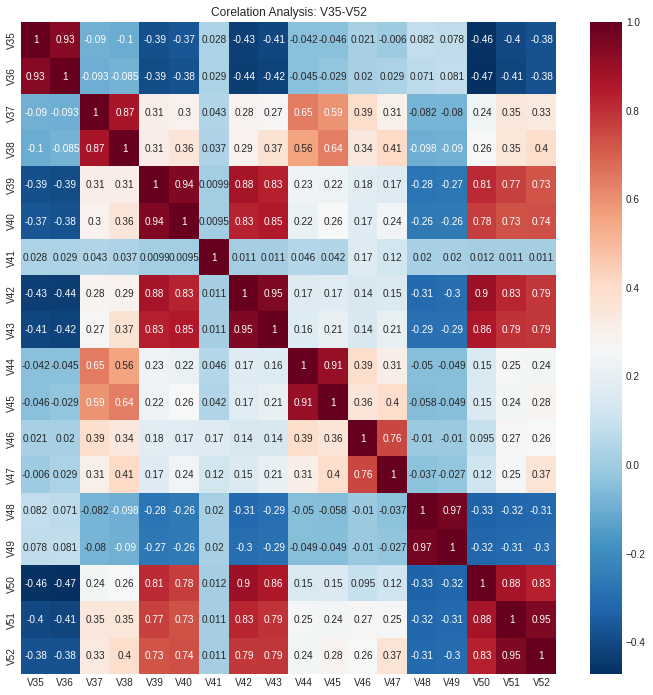

In [ ]:
cols = ['V35', 'V40', 'V41', 'V39', 'V38', 'V51', 'V37', 'V52', 'V36', 'V50', 'V48', 'V42',
 'V43', 'V44', 'V46', 'V47', 'V45', 'V49']

corelation_analysis(cols,title='Corelation Analysis: V35-V52',size=(12,12))

In [ ]:
pairs = [['V35','V36'],['V37','V38'],['V39','V40','V42','V43','V50','V51','V52'],['V41'],
         ['V44','V45'],['V46','V47'],['V48','V49']]
         
return_list = reduce_groups(pairs)
keep_cols.extend(return_list)
keep_cols

['V1',
 'V3',
 'V4',
 'V6',
 'V8',
 'V11',
 'V13',
 'V14',
 'V17',
 'V20',
 'V23',
 'V26',
 'V27',
 'V30',
 'V36',
 'V37',
 'V40',
 'V41',
 'V44',
 'V47',
 'V48']

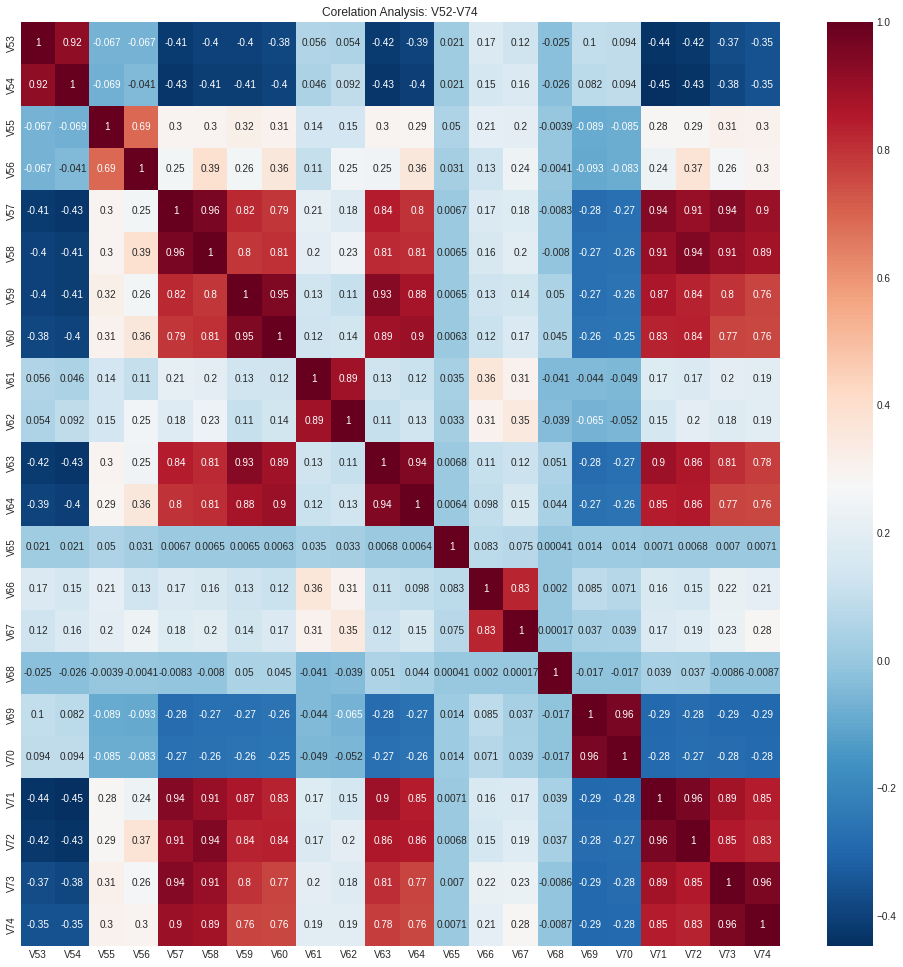

In [ ]:
cols = ['V72', 'V74', 'V73', 'V71', 'V65', 'V68', 'V58', 'V70', 'V53', 
 'V54', 'V55', 'V56', 'V57', 'V59', 'V67', 'V60', 'V61',
 'V62', 'V63', 'V64', 'V66', 'V69']

corelation_analysis(cols,title='Corelation Analysis: V52-V74',size=(17,17))

In [ ]:
pairs = [['V53','V54'],['V55'],['V56'],['V57', 'V58', 'V59', 'V60', 'V63', 'V64', 'V71', 'V72', 'V73', 'V74'],['V61','V62'],
 ['V65'],['V66','V67'],['V68'],['V69','V70']]

return_list = reduce_groups(pairs)
keep_cols.extend(return_list)
keep_cols

['V1',
 'V3',
 'V4',
 'V6',
 'V8',
 'V11',
 'V13',
 'V14',
 'V17',
 'V20',
 'V23',
 'V26',
 'V27',
 'V30',
 'V36',
 'V37',
 'V40',
 'V41',
 'V44',
 'V47',
 'V48',
 'V54',
 'V55',
 'V56',
 'V59',
 'V62',
 'V65',
 'V67',
 'V68',
 'V70']

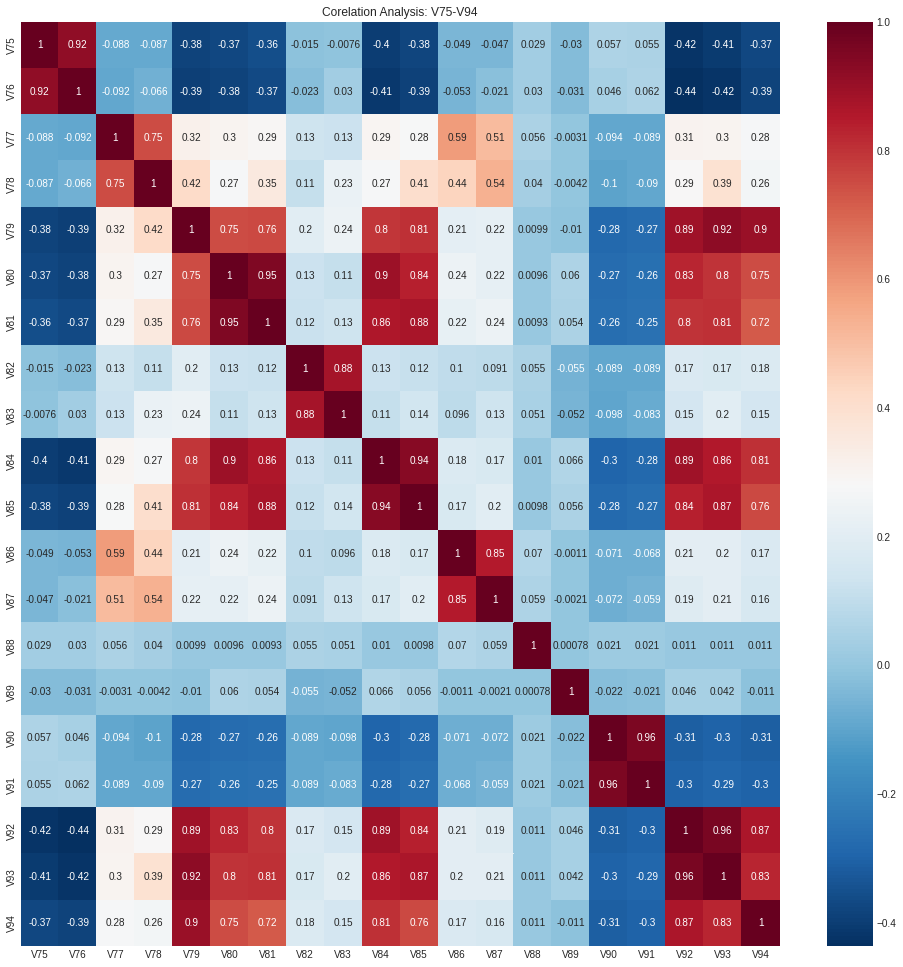

In [ ]:
cols = ['V80', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V86', 'V79',
 'V85', 'V75', 'V84', 'V77', 'V83', 'V78', 'V82', 'V81', 'V76']

corelation_analysis(cols,title='Corelation Analysis: V75-V94',size=(17,17))

In [ ]:
pairs = [['V75','V76'],['V77','V78'],['V79','V80','V81','V84','V85','V92','V93','V94'],['V82','V83'],['V86','V87'],
         ['V88'],['V89'],['V90','V91']]

return_list = reduce_groups(pairs)
keep_cols.extend(return_list)
keep_cols

['V1',
 'V3',
 'V4',
 'V6',
 'V8',
 'V11',
 'V13',
 'V14',
 'V17',
 'V20',
 'V23',
 'V26',
 'V27',
 'V30',
 'V36',
 'V37',
 'V40',
 'V41',
 'V44',
 'V47',
 'V48',
 'V54',
 'V55',
 'V56',
 'V59',
 'V62',
 'V65',
 'V67',
 'V68',
 'V70',
 'V76',
 'V78',
 'V80',
 'V82',
 'V86',
 'V88',
 'V89',
 'V91']

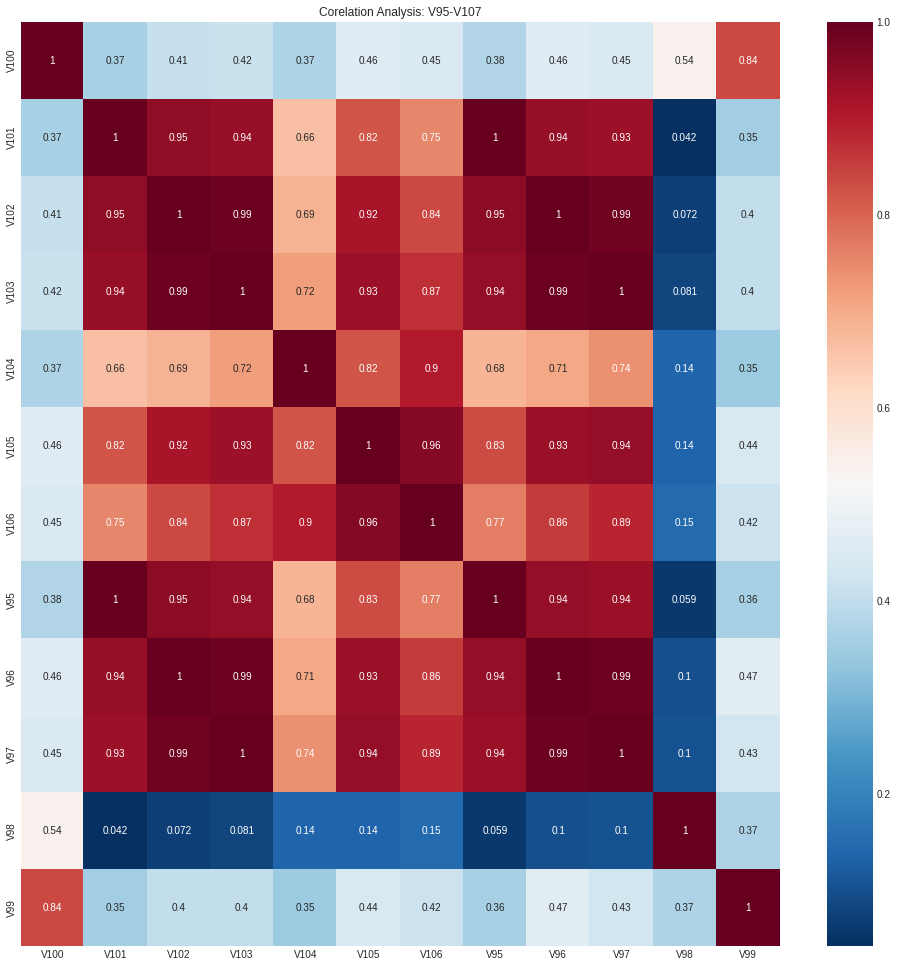

In [ ]:
cols = ['V'+str(x) for x in range(95,107)]

corelation_analysis(cols,title='Corelation Analysis: V95-V107',size=(17,17))

In [ ]:
pairs = [['V99','V100'],['V98'],['V104'],['V95','V96','V97','V101','V102','V103','V105','V106']]

return_list = reduce_groups(pairs)
keep_cols.extend(return_list)
keep_cols

['V1',
 'V3',
 'V4',
 'V6',
 'V8',
 'V11',
 'V13',
 'V14',
 'V17',
 'V20',
 'V23',
 'V26',
 'V27',
 'V30',
 'V36',
 'V37',
 'V40',
 'V41',
 'V44',
 'V47',
 'V48',
 'V54',
 'V55',
 'V56',
 'V59',
 'V62',
 'V65',
 'V67',
 'V68',
 'V70',
 'V76',
 'V78',
 'V80',
 'V82',
 'V86',
 'V88',
 'V89',
 'V91',
 'V99',
 'V98',
 'V104',
 'V96']

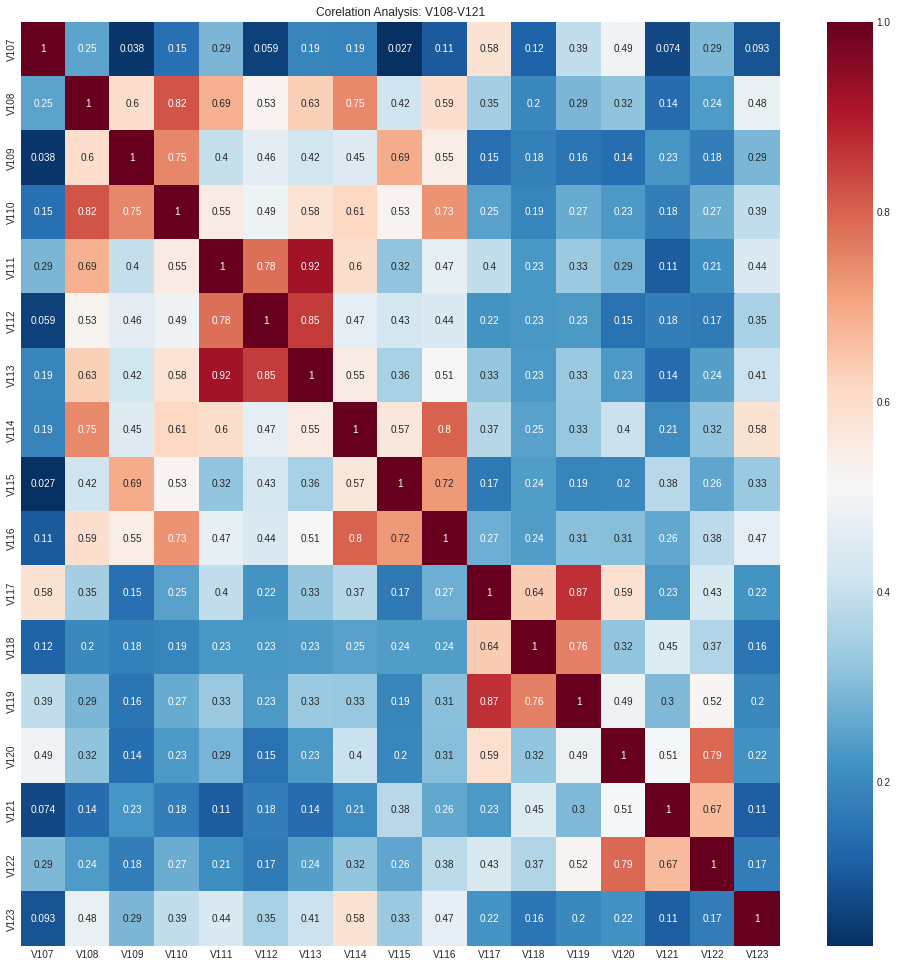

In [ ]:
cols = ['V'+str(x) for x in range(107,124)]

corelation_analysis(cols,title='Corelation Analysis: V108-V121',size=(17,17))

In [ ]:
pairs = [['V107'],['V108','V109','V110','V114'],['V111','V112','V113'],['V115','V116'],['V117','V118','V119'],['V120','V122'],['V121'],['V123']]

return_list = reduce_groups(pairs)
keep_cols.extend(return_list)
keep_cols

['V1',
 'V3',
 'V4',
 'V6',
 'V8',
 'V11',
 'V13',
 'V14',
 'V17',
 'V20',
 'V23',
 'V26',
 'V27',
 'V30',
 'V36',
 'V37',
 'V40',
 'V41',
 'V44',
 'V47',
 'V48',
 'V54',
 'V55',
 'V56',
 'V59',
 'V62',
 'V65',
 'V67',
 'V68',
 'V70',
 'V76',
 'V78',
 'V80',
 'V82',
 'V86',
 'V88',
 'V89',
 'V91',
 'V99',
 'V98',
 'V104',
 'V96',
 'V107',
 'V108',
 'V111',
 'V115',
 'V117',
 'V120',
 'V121',
 'V123']

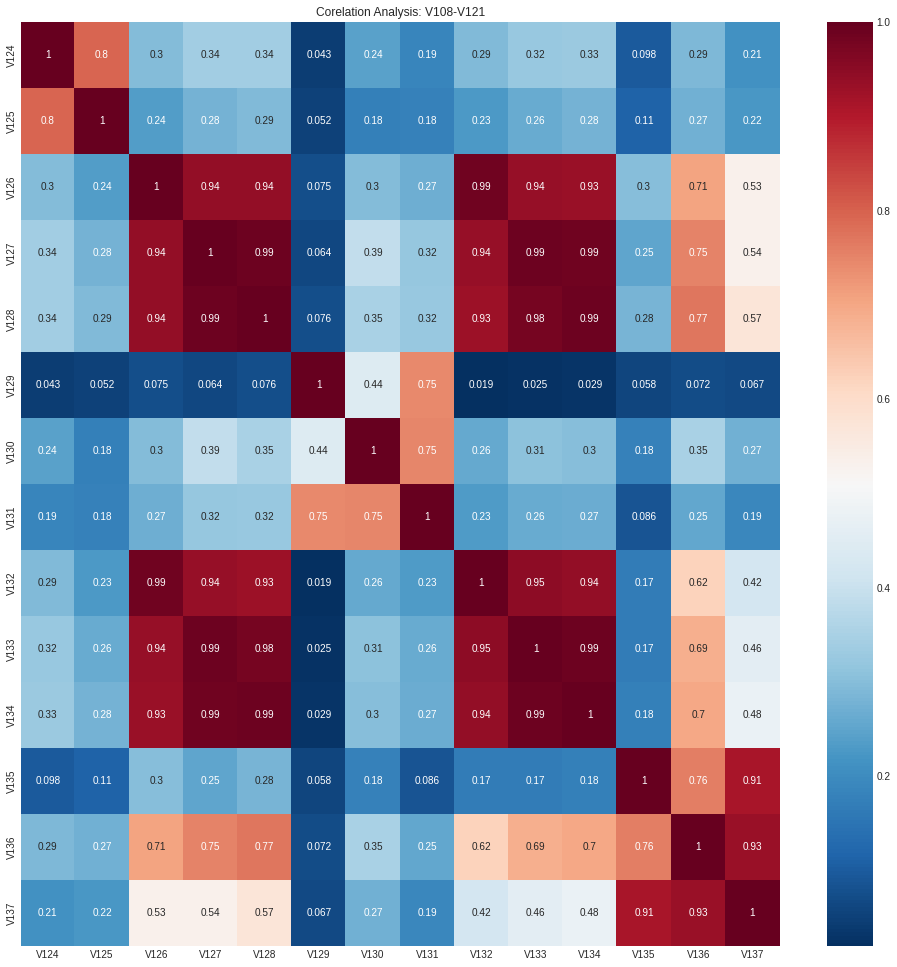

In [ ]:
cols = ['V'+str(x) for x in range(124,138)]
corelation_analysis(cols,title='Corelation Analysis: V108-V121',size=(17,17))

In [ ]:
pairs = [['V124','V125'],['V126','V127','V128','V132','V133','V134'],['V129'],['V130','V131'],['V135','V136','V137']]

return_list = reduce_groups(pairs)
keep_cols.extend(return_list)
keep_cols

['V1',
 'V3',
 'V4',
 'V6',
 'V8',
 'V11',
 'V13',
 'V14',
 'V17',
 'V20',
 'V23',
 'V26',
 'V27',
 'V30',
 'V36',
 'V37',
 'V40',
 'V41',
 'V44',
 'V47',
 'V48',
 'V54',
 'V55',
 'V56',
 'V59',
 'V62',
 'V65',
 'V67',
 'V68',
 'V70',
 'V76',
 'V78',
 'V80',
 'V82',
 'V86',
 'V88',
 'V89',
 'V91',
 'V99',
 'V98',
 'V104',
 'V96',
 'V107',
 'V108',
 'V111',
 'V115',
 'V117',
 'V120',
 'V121',
 'V123',
 'V124',
 'V127',
 'V129',
 'V130',
 'V136']

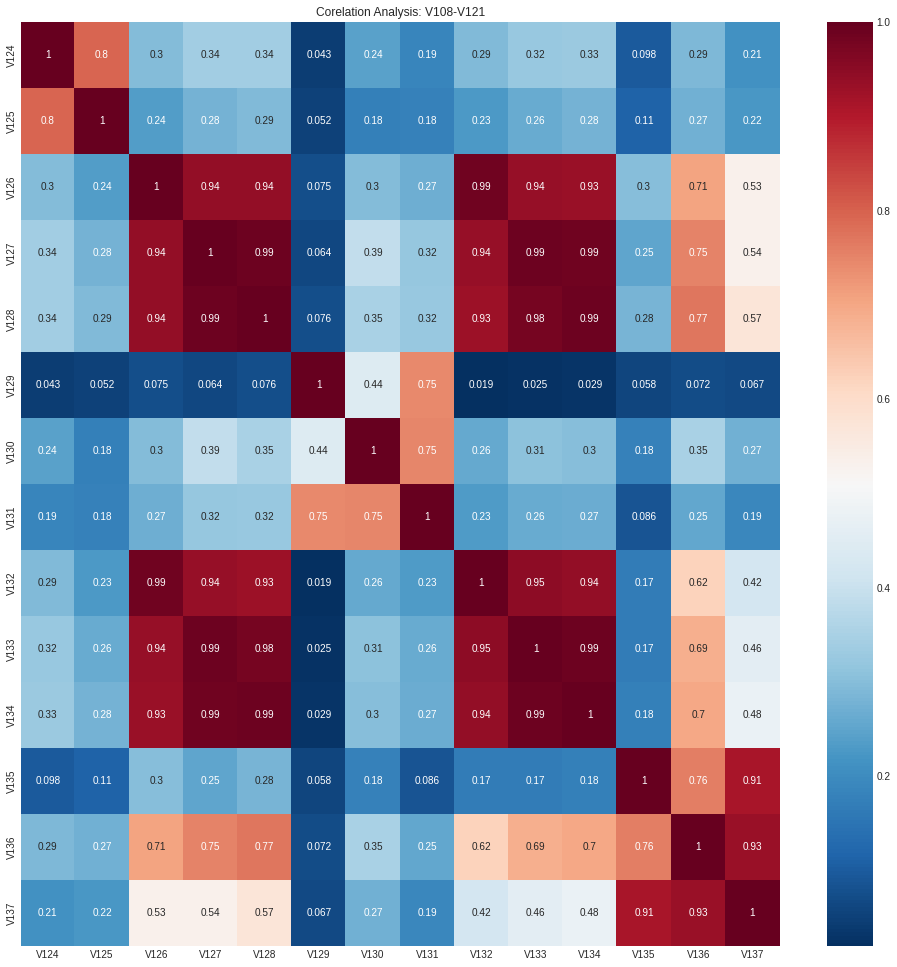

In [ ]:
cols = ['V'+str(x) for x in range(124,138)]
corelation_analysis(cols,title='Corelation Analysis: V108-V121',size=(17,17))

In [ ]:
pairs = [['V124','V125'],['V126','V127','V128','V132','V133','V134'],['V129'],['V130','V131'],['V135','V136','V137']]

return_list = reduce_groups(pairs)
keep_cols.extend(return_list)
keep_cols

['V1',
 'V3',
 'V4',
 'V6',
 'V8',
 'V11',
 'V13',
 'V14',
 'V17',
 'V20',
 'V23',
 'V26',
 'V27',
 'V30',
 'V36',
 'V37',
 'V40',
 'V41',
 'V44',
 'V47',
 'V48',
 'V54',
 'V55',
 'V56',
 'V59',
 'V62',
 'V65',
 'V67',
 'V68',
 'V70',
 'V76',
 'V78',
 'V80',
 'V82',
 'V86',
 'V88',
 'V89',
 'V91',
 'V99',
 'V98',
 'V104',
 'V96',
 'V107',
 'V108',
 'V111',
 'V115',
 'V117',
 'V120',
 'V121',
 'V123',
 'V124',
 'V127',
 'V129',
 'V130',
 'V136',
 'V124',
 'V127',
 'V129',
 'V130',
 'V136']

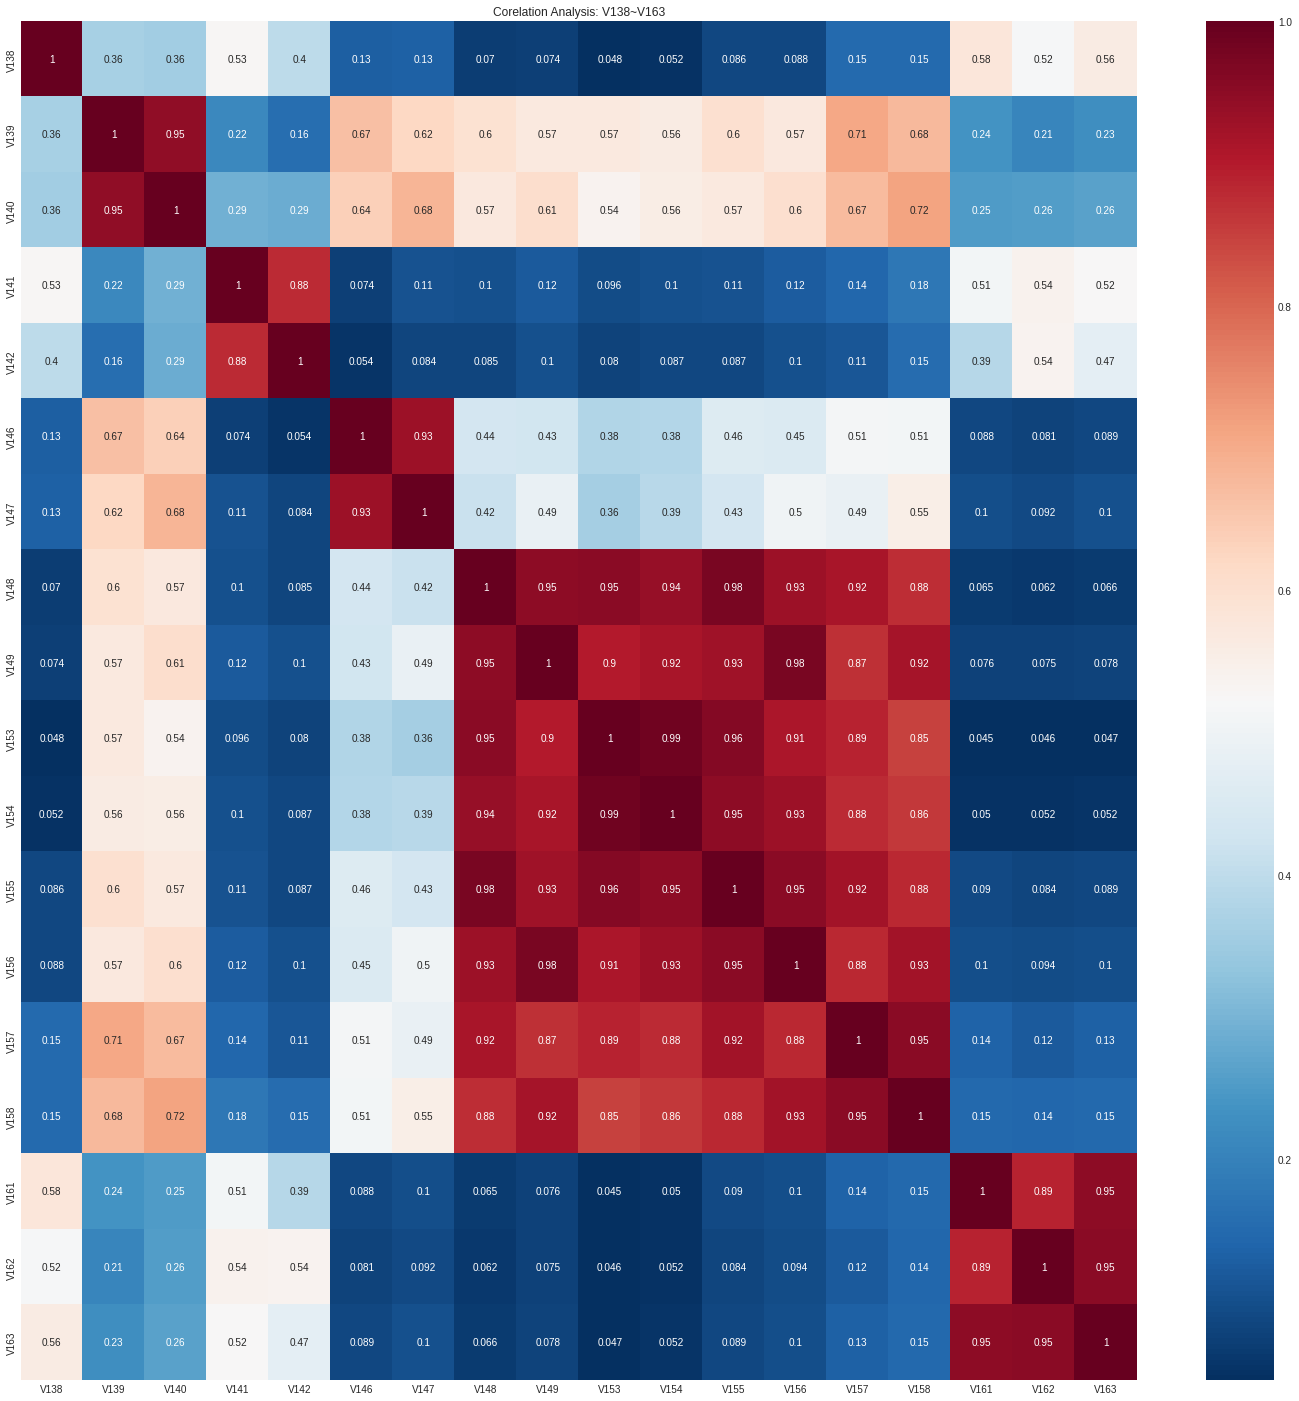

In [ ]:
cols = ['V142', 'V158', 'V140', 'V162', 'V141', 'V161', 'V157', 'V146', 'V156', 'V155', 'V154',
        'V153', 'V149', 'V147', 'V148', 'V163', 'V139', 'V138']

corelation_analysis(cols,title='Corelation Analysis: V138~V163',size=(25,25))

In [ ]:
pairs = [['V138'],['V139','V140'],['V141','V142'],['V146','V147'],['V148','V149','V153','V154','V156','V157','V158'],['V161','V162','V163']]

return_list = reduce_groups(pairs)
keep_cols.extend(return_list)
keep_cols

['V1',
 'V3',
 'V4',
 'V6',
 'V8',
 'V11',
 'V13',
 'V14',
 'V17',
 'V20',
 'V23',
 'V26',
 'V27',
 'V30',
 'V36',
 'V37',
 'V40',
 'V41',
 'V44',
 'V47',
 'V48',
 'V54',
 'V55',
 'V56',
 'V59',
 'V62',
 'V65',
 'V67',
 'V68',
 'V70',
 'V76',
 'V78',
 'V80',
 'V82',
 'V86',
 'V88',
 'V89',
 'V91',
 'V99',
 'V98',
 'V104',
 'V96',
 'V107',
 'V108',
 'V111',
 'V115',
 'V117',
 'V120',
 'V121',
 'V123',
 'V124',
 'V127',
 'V129',
 'V130',
 'V136',
 'V124',
 'V127',
 'V129',
 'V130',
 'V136',
 'V138',
 'V139',
 'V142',
 'V147',
 'V156',
 'V162']

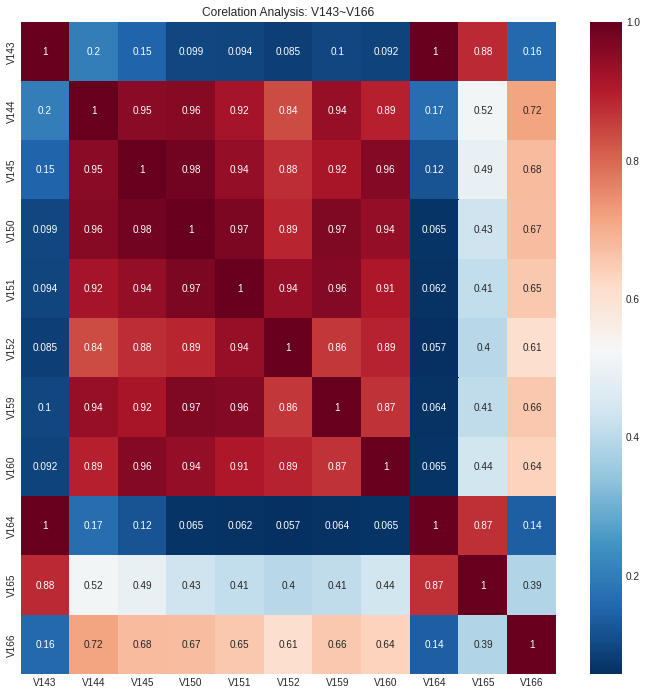

In [ ]:
cols = ['V160', 'V151', 'V152', 'V145', 'V144', 'V143', 'V159', 'V164', 'V165', 'V166', 'V150']

corelation_analysis(cols,title='Corelation Analysis: V143~V166',size=(12,12))

In [ ]:
pairs = [['V143','V164','V165'],['V144','V145','V150','V151','V152','V159','V160'],['V166']]

return_list = reduce_groups(pairs)
keep_cols.extend(return_list)
keep_cols

['V1',
 'V3',
 'V4',
 'V6',
 'V8',
 'V11',
 'V13',
 'V14',
 'V17',
 'V20',
 'V23',
 'V26',
 'V27',
 'V30',
 'V36',
 'V37',
 'V40',
 'V41',
 'V44',
 'V47',
 'V48',
 'V54',
 'V55',
 'V56',
 'V59',
 'V62',
 'V65',
 'V67',
 'V68',
 'V70',
 'V76',
 'V78',
 'V80',
 'V82',
 'V86',
 'V88',
 'V89',
 'V91',
 'V99',
 'V98',
 'V104',
 'V96',
 'V107',
 'V108',
 'V111',
 'V115',
 'V117',
 'V120',
 'V121',
 'V123',
 'V124',
 'V127',
 'V129',
 'V130',
 'V136',
 'V124',
 'V127',
 'V129',
 'V130',
 'V136',
 'V138',
 'V139',
 'V142',
 'V147',
 'V156',
 'V162',
 'V165',
 'V160',
 'V166']

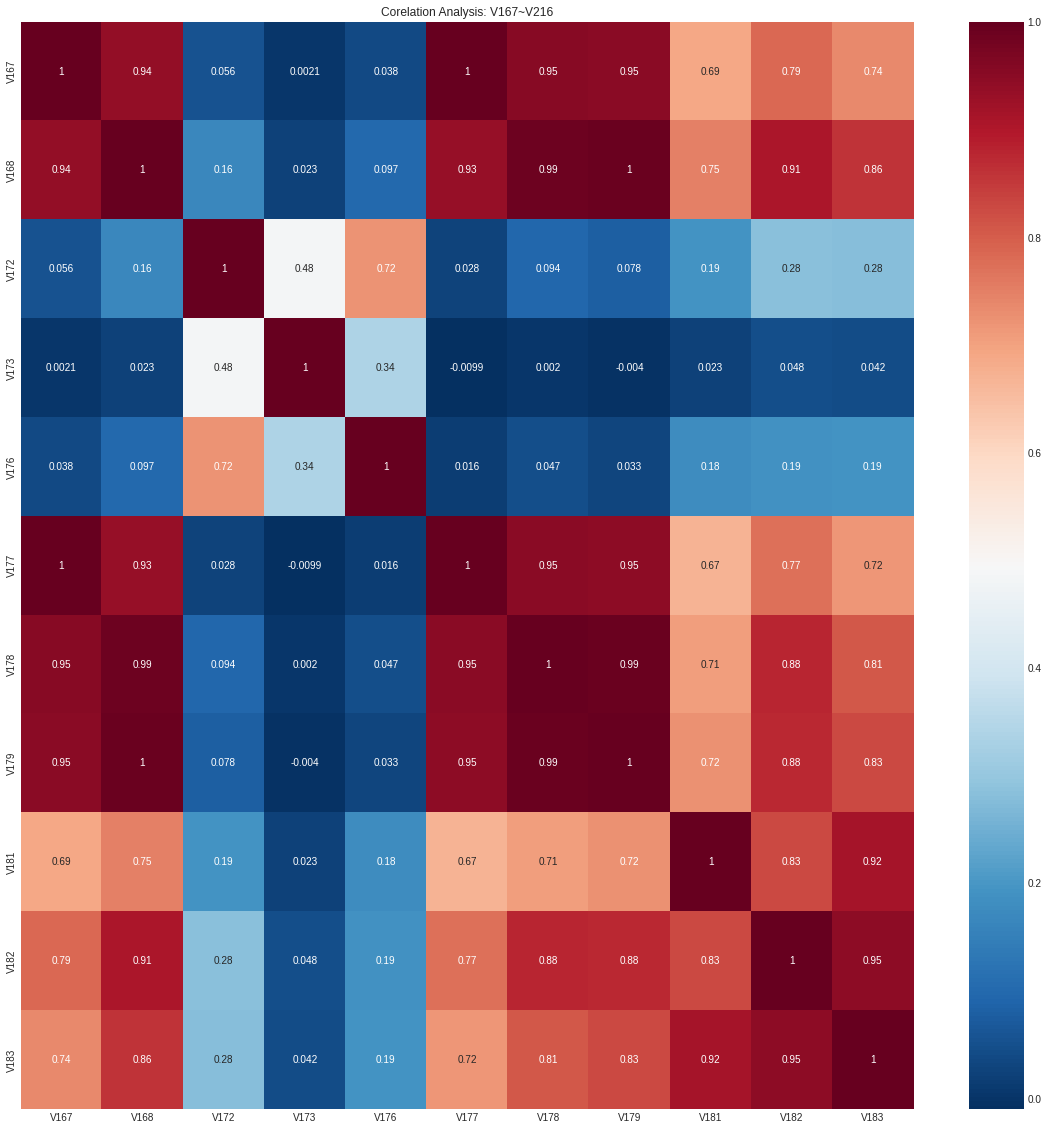

In [ ]:
cols = ['V167', 'V168','V172','V173','V176','V177','V178','V179','V181','V182','V183']

corelation_analysis(cols,title='Corelation Analysis: V167~V216',size=(20,20))

In [ ]:
pairs = [['V167','V168','V177','V178','V179'],['V172','V176'],['V173'],['V181','V182','V183']]

return_list = reduce_groups(pairs)
keep_cols.extend(return_list)
keep_cols

['V1',
 'V3',
 'V4',
 'V6',
 'V8',
 'V11',
 'V13',
 'V14',
 'V17',
 'V20',
 'V23',
 'V26',
 'V27',
 'V30',
 'V36',
 'V37',
 'V40',
 'V41',
 'V44',
 'V47',
 'V48',
 'V54',
 'V55',
 'V56',
 'V59',
 'V62',
 'V65',
 'V67',
 'V68',
 'V70',
 'V76',
 'V78',
 'V80',
 'V82',
 'V86',
 'V88',
 'V89',
 'V91',
 'V99',
 'V98',
 'V104',
 'V96',
 'V107',
 'V108',
 'V111',
 'V115',
 'V117',
 'V120',
 'V121',
 'V123',
 'V124',
 'V127',
 'V129',
 'V130',
 'V136',
 'V124',
 'V127',
 'V129',
 'V130',
 'V136',
 'V138',
 'V139',
 'V142',
 'V147',
 'V156',
 'V162',
 'V165',
 'V160',
 'V166',
 'V178',
 'V176',
 'V173',
 'V182']

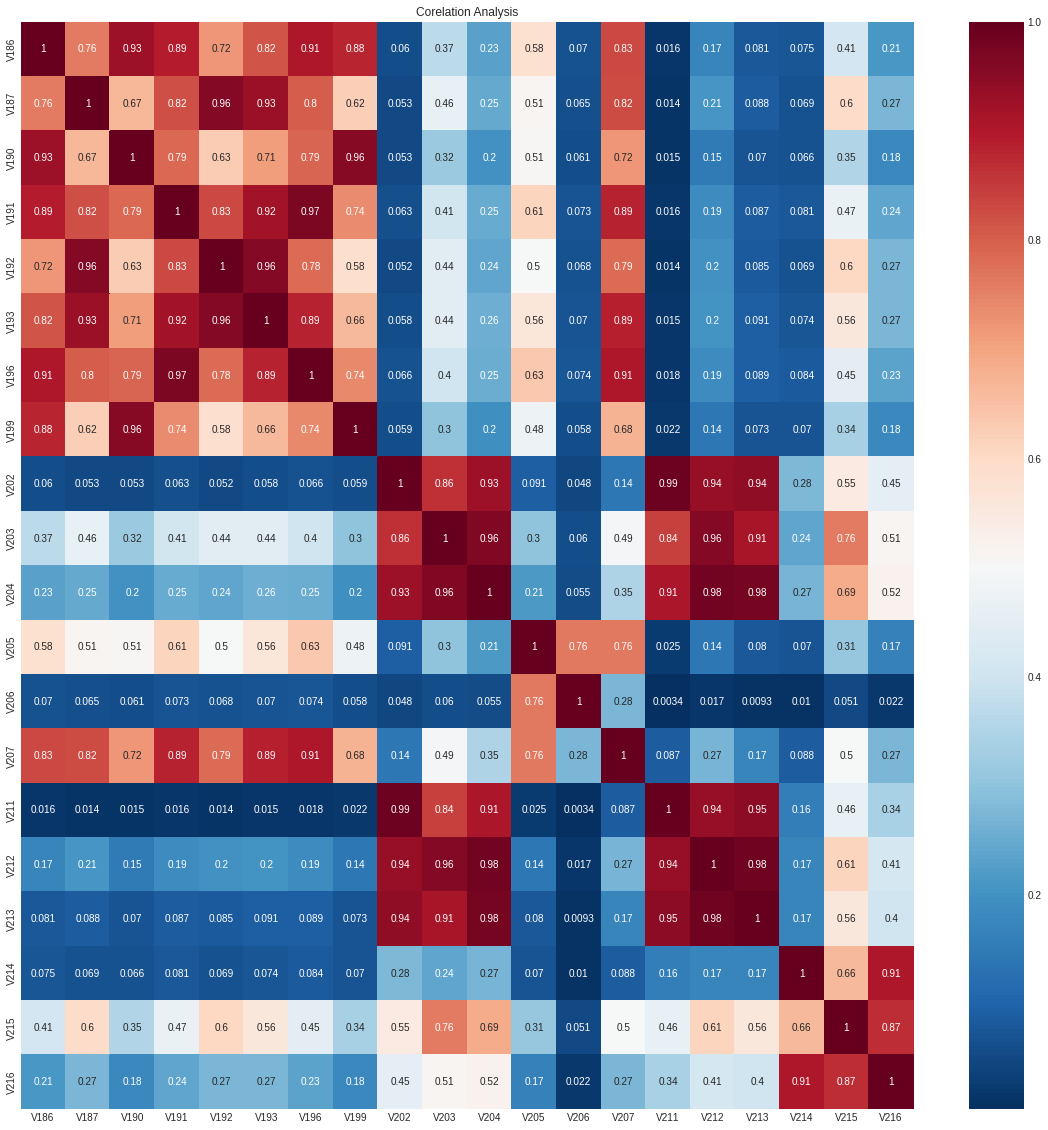

In [ ]:
cols = ['V186','V187','V190','V191','V192','V193','V196','V199','V202','V203','V204','V211','V212','V213','V205','V206','V207','V214','V215','V216']

corelation_analysis(cols,title='Corelation Analysis',size=(20,20))

In [ ]:
pairs = [['V186','V187','V190','V191','V192','V193','V196','V199'],['V202','V203','V204','V211','V212','V213'],['V205','V206'],['V207'],['V214','V215','V216']]

return_list = reduce_groups(pairs)
keep_cols.extend(return_list)
keep_cols

['V1',
 'V3',
 'V4',
 'V6',
 'V8',
 'V11',
 'V13',
 'V14',
 'V17',
 'V20',
 'V23',
 'V26',
 'V27',
 'V30',
 'V36',
 'V37',
 'V40',
 'V41',
 'V44',
 'V47',
 'V48',
 'V54',
 'V55',
 'V56',
 'V59',
 'V62',
 'V65',
 'V67',
 'V68',
 'V70',
 'V76',
 'V78',
 'V80',
 'V82',
 'V86',
 'V88',
 'V89',
 'V91',
 'V99',
 'V98',
 'V104',
 'V96',
 'V107',
 'V108',
 'V111',
 'V115',
 'V117',
 'V120',
 'V121',
 'V123',
 'V124',
 'V127',
 'V129',
 'V130',
 'V136',
 'V124',
 'V127',
 'V129',
 'V130',
 'V136',
 'V138',
 'V139',
 'V142',
 'V147',
 'V156',
 'V162',
 'V165',
 'V160',
 'V166',
 'V178',
 'V176',
 'V173',
 'V182',
 'V187',
 'V203',
 'V205',
 'V207',
 'V215']

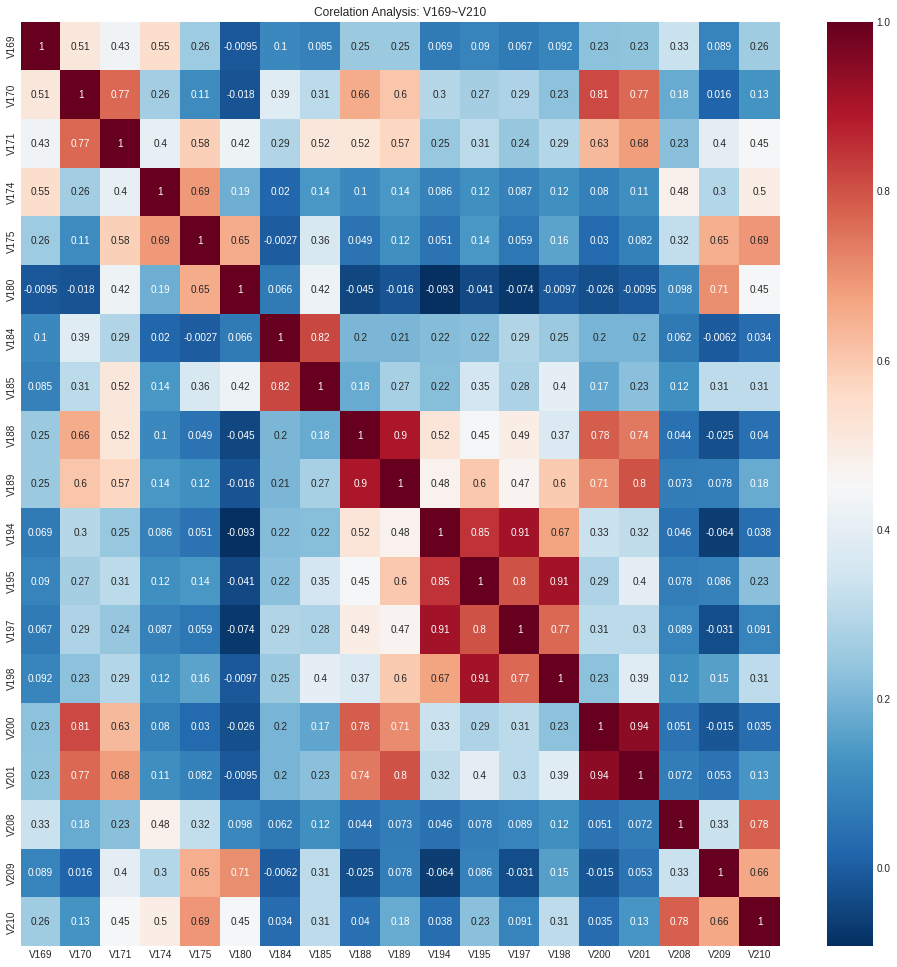

In [ ]:
cols = ['V194', 'V200', 'V189', 'V188', 'V185', 'V184', 'V180', 'V175', 'V174', 'V171', 'V170', 'V169', 'V195', 'V201', 'V197', 'V198', 'V209', 'V208', 'V210']

corelation_analysis(cols,title='Corelation Analysis: V169~V210',size=(17,17))

In [ ]:
pairs = [['V169'],['V170','V171','V200','V201'],['V174','V175'],['V180'],['V184','V185'],['V188','V189'],['V194','V195','V197','V198'],['V208','V210'],
         ['V209']]

return_list = reduce_groups(pairs)
keep_cols.extend(return_list)
keep_cols

['V1',
 'V3',
 'V4',
 'V6',
 'V8',
 'V11',
 'V13',
 'V14',
 'V17',
 'V20',
 'V23',
 'V26',
 'V27',
 'V30',
 'V36',
 'V37',
 'V40',
 'V41',
 'V44',
 'V47',
 'V48',
 'V54',
 'V55',
 'V56',
 'V59',
 'V62',
 'V65',
 'V67',
 'V68',
 'V70',
 'V76',
 'V78',
 'V80',
 'V82',
 'V86',
 'V88',
 'V89',
 'V91',
 'V99',
 'V98',
 'V104',
 'V96',
 'V107',
 'V108',
 'V111',
 'V115',
 'V117',
 'V120',
 'V121',
 'V123',
 'V124',
 'V127',
 'V129',
 'V130',
 'V136',
 'V124',
 'V127',
 'V129',
 'V130',
 'V136',
 'V138',
 'V139',
 'V142',
 'V147',
 'V156',
 'V162',
 'V165',
 'V160',
 'V166',
 'V178',
 'V176',
 'V173',
 'V182',
 'V187',
 'V203',
 'V205',
 'V207',
 'V215',
 'V169',
 'V171',
 'V175',
 'V180',
 'V185',
 'V188',
 'V198',
 'V210',
 'V209']

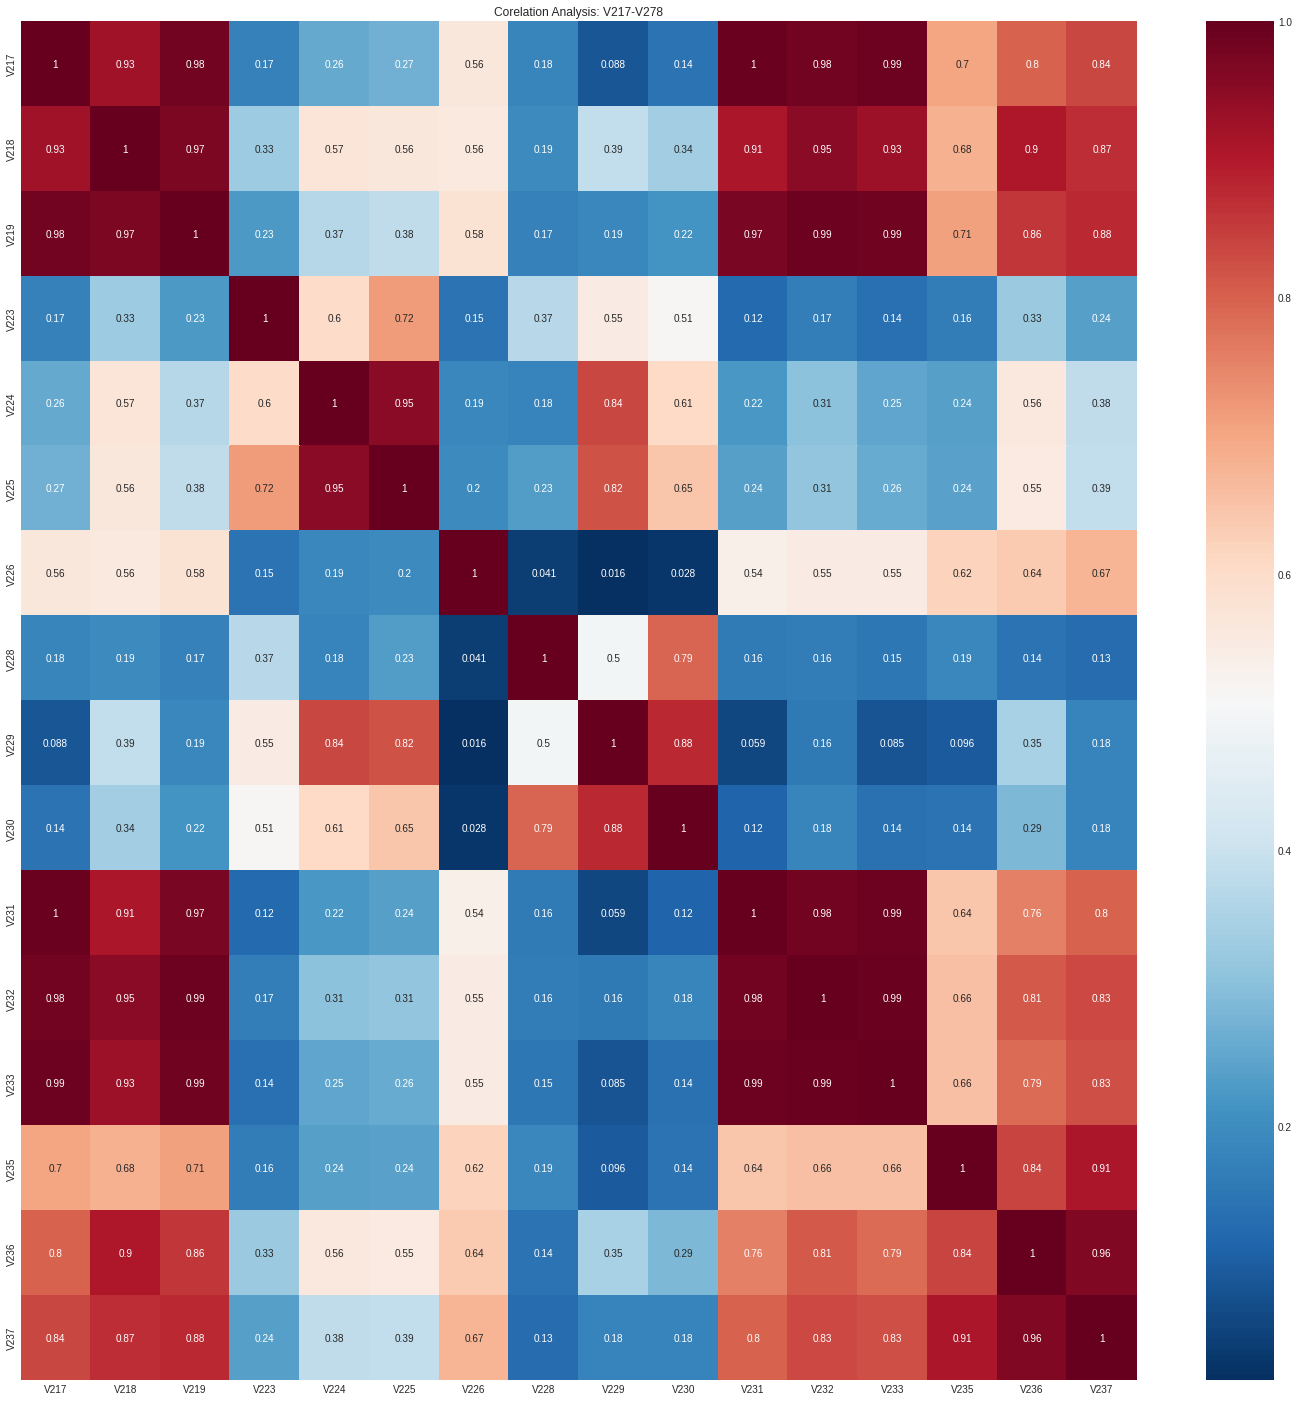

In [ ]:
cols = ['V217','V218','V219','V231','V232','V233','V236','V237','V223','V224','V225','V226','V228','V229','V230','V235']

corelation_analysis(cols,title='Corelation Analysis: V217-V278',size=(25,25))

In [ ]:
pairs = [['V217','V218','V219','V231','V232','V233','V236','V237'],['V223'],['V224','V225'],['V226'],['V228'],['V229','V230'],['V235']]

return_list = reduce_groups(pairs)
keep_cols.extend(return_list)
keep_cols

['V1',
 'V3',
 'V4',
 'V6',
 'V8',
 'V11',
 'V13',
 'V14',
 'V17',
 'V20',
 'V23',
 'V26',
 'V27',
 'V30',
 'V36',
 'V37',
 'V40',
 'V41',
 'V44',
 'V47',
 'V48',
 'V54',
 'V55',
 'V56',
 'V59',
 'V62',
 'V65',
 'V67',
 'V68',
 'V70',
 'V76',
 'V78',
 'V80',
 'V82',
 'V86',
 'V88',
 'V89',
 'V91',
 'V99',
 'V98',
 'V104',
 'V96',
 'V107',
 'V108',
 'V111',
 'V115',
 'V117',
 'V120',
 'V121',
 'V123',
 'V124',
 'V127',
 'V129',
 'V130',
 'V136',
 'V124',
 'V127',
 'V129',
 'V130',
 'V136',
 'V138',
 'V139',
 'V142',
 'V147',
 'V156',
 'V162',
 'V165',
 'V160',
 'V166',
 'V178',
 'V176',
 'V173',
 'V182',
 'V187',
 'V203',
 'V205',
 'V207',
 'V215',
 'V169',
 'V171',
 'V175',
 'V180',
 'V185',
 'V188',
 'V198',
 'V210',
 'V209',
 'V218',
 'V223',
 'V224',
 'V226',
 'V228',
 'V229',
 'V235']

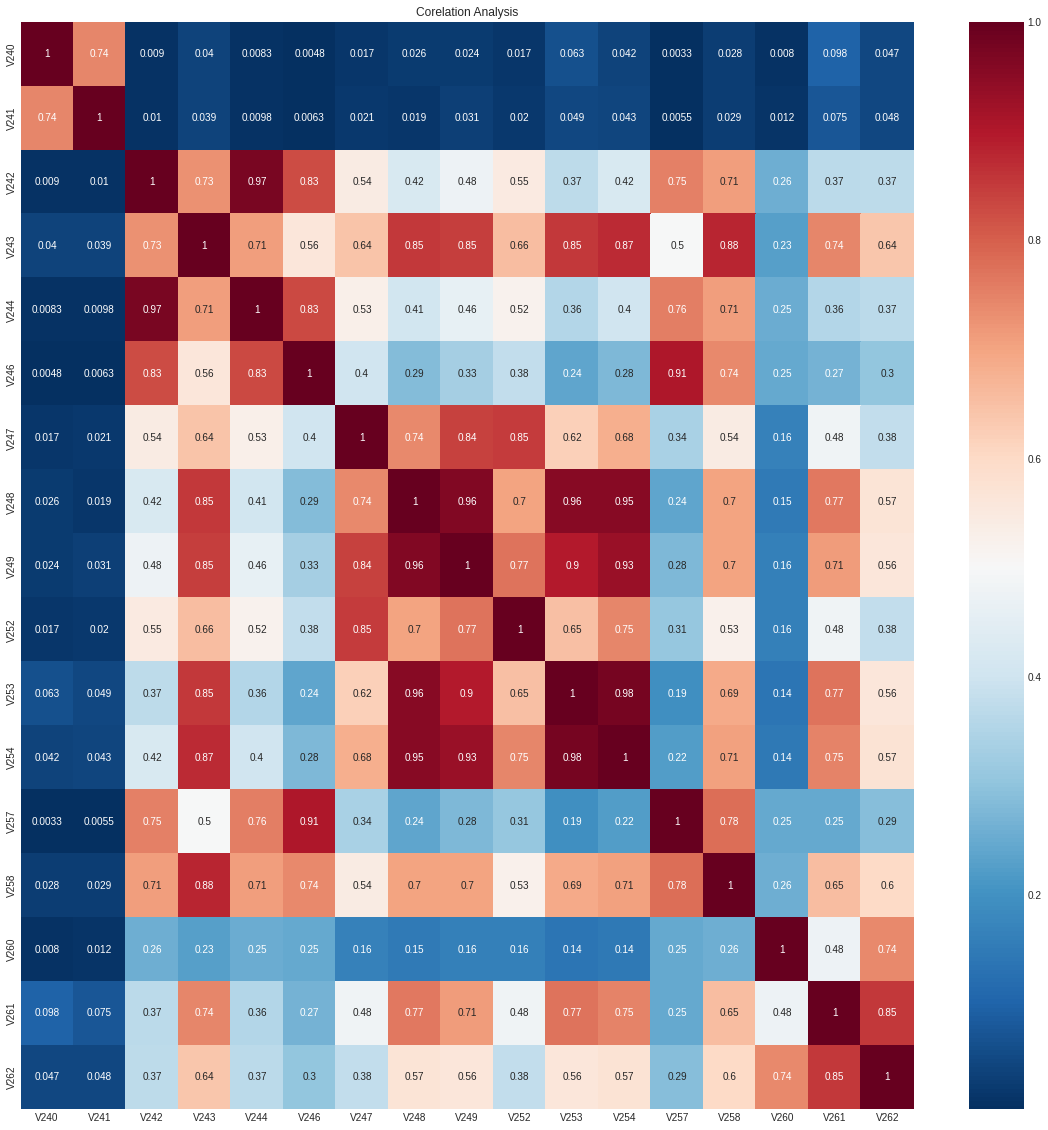

In [ ]:
cols = ['V240','V241','V242','V243','V244','V258','V246','V257','V247','V248','V249','V253','V254','V252','V260','V261','V262']

corelation_analysis(cols,title='Corelation Analysis',size=(20,20))

In [ ]:
pairs = [['V240','V241'],['V242','V243','V244','V258'],['V246','V257'],['V247','V248','V249','V253','V254'],['V252'],['V260'],['V261','V262']]
         
return_list = reduce_groups(pairs)
keep_cols.extend(return_list)
keep_cols

['V1',
 'V3',
 'V4',
 'V6',
 'V8',
 'V11',
 'V13',
 'V14',
 'V17',
 'V20',
 'V23',
 'V26',
 'V27',
 'V30',
 'V36',
 'V37',
 'V40',
 'V41',
 'V44',
 'V47',
 'V48',
 'V54',
 'V55',
 'V56',
 'V59',
 'V62',
 'V65',
 'V67',
 'V68',
 'V70',
 'V76',
 'V78',
 'V80',
 'V82',
 'V86',
 'V88',
 'V89',
 'V91',
 'V99',
 'V98',
 'V104',
 'V96',
 'V107',
 'V108',
 'V111',
 'V115',
 'V117',
 'V120',
 'V121',
 'V123',
 'V124',
 'V127',
 'V129',
 'V130',
 'V136',
 'V124',
 'V127',
 'V129',
 'V130',
 'V136',
 'V138',
 'V139',
 'V142',
 'V147',
 'V156',
 'V162',
 'V165',
 'V160',
 'V166',
 'V178',
 'V176',
 'V173',
 'V182',
 'V187',
 'V203',
 'V205',
 'V207',
 'V215',
 'V169',
 'V171',
 'V175',
 'V180',
 'V185',
 'V188',
 'V198',
 'V210',
 'V209',
 'V218',
 'V223',
 'V224',
 'V226',
 'V228',
 'V229',
 'V235',
 'V240',
 'V258',
 'V257',
 'V253',
 'V252',
 'V260',
 'V261']

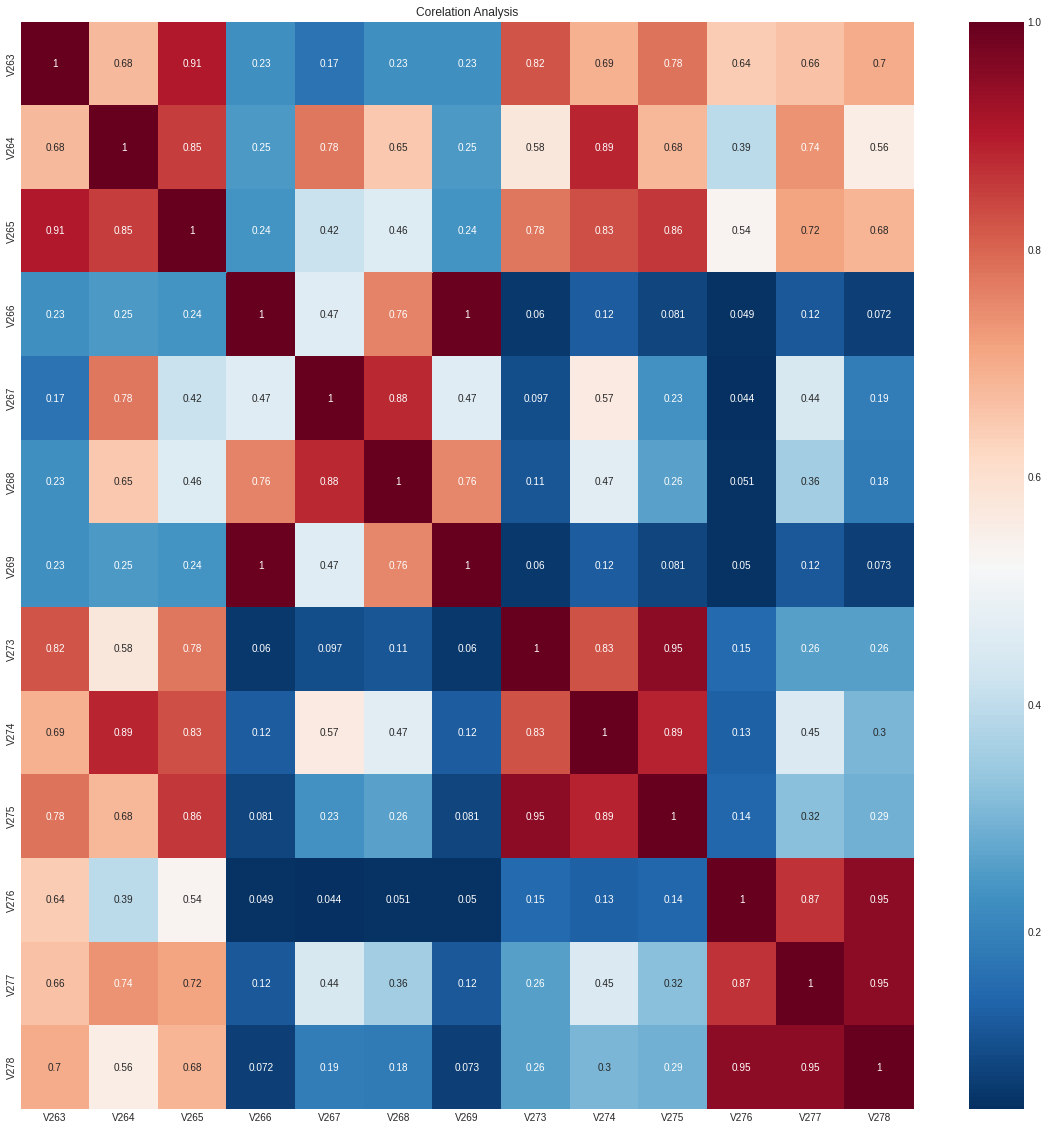

In [ ]:
cols =  ['V263','V265','V264','V266','V269','V267','V268','V273','V274','V275','V276','V277','V278']

corelation_analysis(cols,title='Corelation Analysis',size=(20,20))

In [ ]:
pairs =[['V263','V265','V264'],['V266','V269'],['V267','V268'],['V273','V274','V275'],['V276','V277','V278']]
         
return_list = reduce_groups(pairs)
keep_cols.extend(return_list)
keep_cols

['V1',
 'V3',
 'V4',
 'V6',
 'V8',
 'V11',
 'V13',
 'V14',
 'V17',
 'V20',
 'V23',
 'V26',
 'V27',
 'V30',
 'V36',
 'V37',
 'V40',
 'V41',
 'V44',
 'V47',
 'V48',
 'V54',
 'V55',
 'V56',
 'V59',
 'V62',
 'V65',
 'V67',
 'V68',
 'V70',
 'V76',
 'V78',
 'V80',
 'V82',
 'V86',
 'V88',
 'V89',
 'V91',
 'V99',
 'V98',
 'V104',
 'V96',
 'V107',
 'V108',
 'V111',
 'V115',
 'V117',
 'V120',
 'V121',
 'V123',
 'V124',
 'V127',
 'V129',
 'V130',
 'V136',
 'V124',
 'V127',
 'V129',
 'V130',
 'V136',
 'V138',
 'V139',
 'V142',
 'V147',
 'V156',
 'V162',
 'V165',
 'V160',
 'V166',
 'V178',
 'V176',
 'V173',
 'V182',
 'V187',
 'V203',
 'V205',
 'V207',
 'V215',
 'V169',
 'V171',
 'V175',
 'V180',
 'V185',
 'V188',
 'V198',
 'V210',
 'V209',
 'V218',
 'V223',
 'V224',
 'V226',
 'V228',
 'V229',
 'V235',
 'V240',
 'V258',
 'V257',
 'V253',
 'V252',
 'V260',
 'V261',
 'V264',
 'V266',
 'V267',
 'V274',
 'V277']

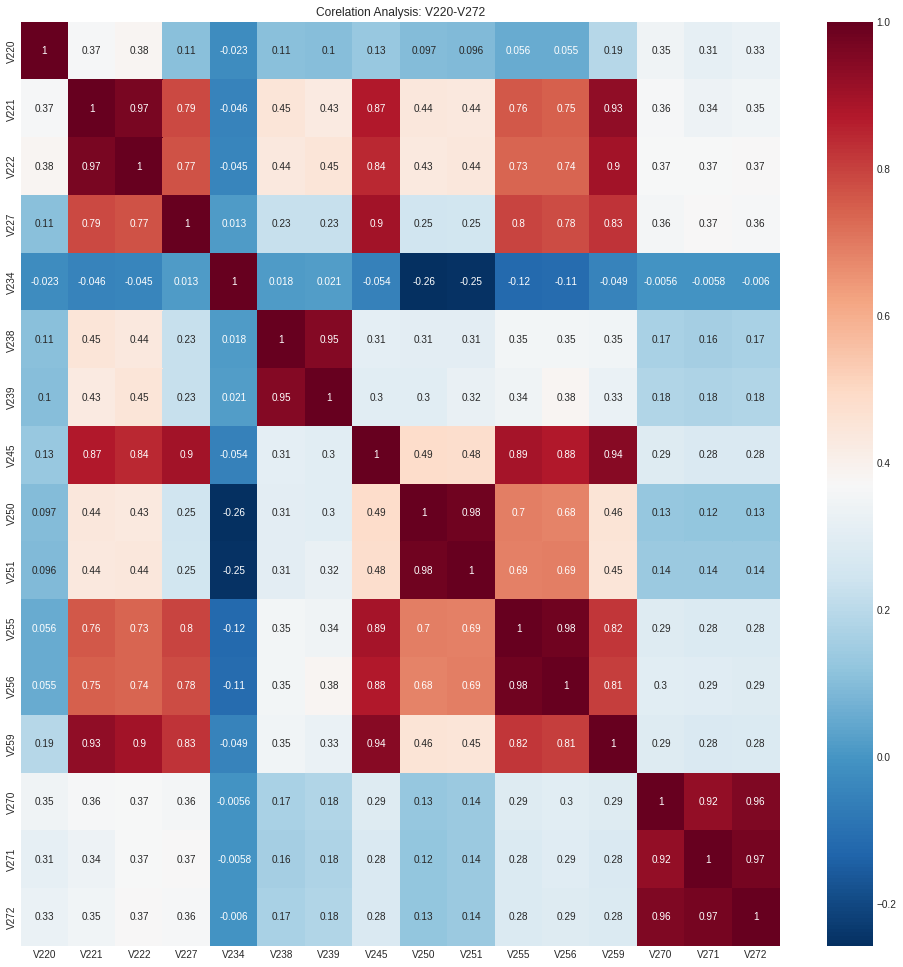

In [ ]:
cols = ['V245', 'V271', 'V234', 'V222', 'V238', 'V239', 'V227', 'V250', 'V272', 'V270', 'V251', 'V220', 'V255', 'V256', 'V259', 'V221']

corelation_analysis(cols,title='Corelation Analysis: V220-V272',size=(17,17))

In [ ]:
pairs = [['V220'],['V221','V222','V227','V245','V255','V256','V259'],['V234'],['V238','V239'],
         ['V250','V251'],['V270','V271','V272']]
         
return_list = reduce_groups(pairs)
keep_cols.extend(return_list)
keep_cols

['V1',
 'V3',
 'V4',
 'V6',
 'V8',
 'V11',
 'V13',
 'V14',
 'V17',
 'V20',
 'V23',
 'V26',
 'V27',
 'V30',
 'V36',
 'V37',
 'V40',
 'V41',
 'V44',
 'V47',
 'V48',
 'V54',
 'V55',
 'V56',
 'V59',
 'V62',
 'V65',
 'V67',
 'V68',
 'V70',
 'V76',
 'V78',
 'V80',
 'V82',
 'V86',
 'V88',
 'V89',
 'V91',
 'V99',
 'V98',
 'V104',
 'V96',
 'V107',
 'V108',
 'V111',
 'V115',
 'V117',
 'V120',
 'V121',
 'V123',
 'V124',
 'V127',
 'V129',
 'V130',
 'V136',
 'V124',
 'V127',
 'V129',
 'V130',
 'V136',
 'V138',
 'V139',
 'V142',
 'V147',
 'V156',
 'V162',
 'V165',
 'V160',
 'V166',
 'V178',
 'V176',
 'V173',
 'V182',
 'V187',
 'V203',
 'V205',
 'V207',
 'V215',
 'V169',
 'V171',
 'V175',
 'V180',
 'V185',
 'V188',
 'V198',
 'V210',
 'V209',
 'V218',
 'V223',
 'V224',
 'V226',
 'V228',
 'V229',
 'V235',
 'V240',
 'V258',
 'V257',
 'V253',
 'V252',
 'V260',
 'V261',
 'V264',
 'V266',
 'V267',
 'V274',
 'V277',
 'V220',
 'V221',
 'V234',
 'V238',
 'V250',
 'V271']

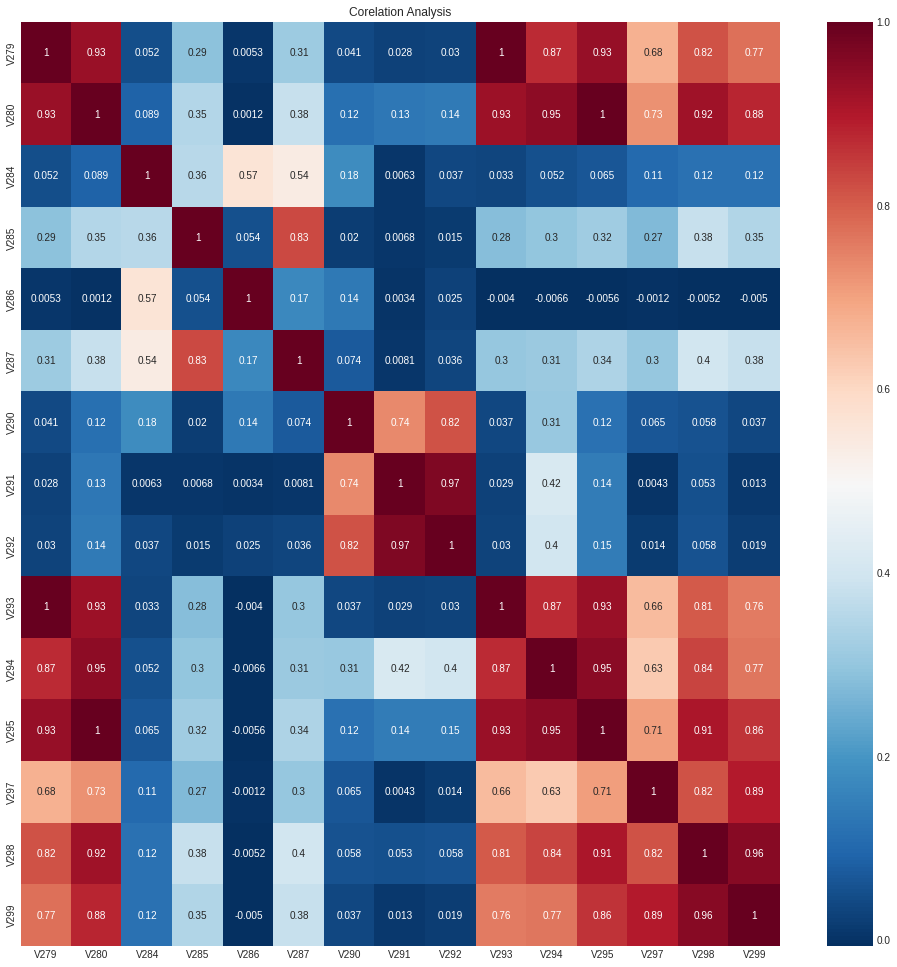

In [ ]:
cols = ['V279','V280','V293','V294','V295','V298','V299','V284','V285','V287','V286','V290','V291','V292','V297']

corelation_analysis(cols,title='Corelation Analysis',size=(17,17))

In [ ]:
pairs = [['V279','V280','V293','V294','V295','V298','V299'],['V284'],['V285','V287'],['V286'],['V290','V291','V292'],['V297']]
         
return_list = reduce_groups(pairs)
keep_cols.extend(return_list)
keep_cols

['V1',
 'V3',
 'V4',
 'V6',
 'V8',
 'V11',
 'V13',
 'V14',
 'V17',
 'V20',
 'V23',
 'V26',
 'V27',
 'V30',
 'V36',
 'V37',
 'V40',
 'V41',
 'V44',
 'V47',
 'V48',
 'V54',
 'V55',
 'V56',
 'V59',
 'V62',
 'V65',
 'V67',
 'V68',
 'V70',
 'V76',
 'V78',
 'V80',
 'V82',
 'V86',
 'V88',
 'V89',
 'V91',
 'V99',
 'V98',
 'V104',
 'V96',
 'V107',
 'V108',
 'V111',
 'V115',
 'V117',
 'V120',
 'V121',
 'V123',
 'V124',
 'V127',
 'V129',
 'V130',
 'V136',
 'V124',
 'V127',
 'V129',
 'V130',
 'V136',
 'V138',
 'V139',
 'V142',
 'V147',
 'V156',
 'V162',
 'V165',
 'V160',
 'V166',
 'V178',
 'V176',
 'V173',
 'V182',
 'V187',
 'V203',
 'V205',
 'V207',
 'V215',
 'V169',
 'V171',
 'V175',
 'V180',
 'V185',
 'V188',
 'V198',
 'V210',
 'V209',
 'V218',
 'V223',
 'V224',
 'V226',
 'V228',
 'V229',
 'V235',
 'V240',
 'V258',
 'V257',
 'V253',
 'V252',
 'V260',
 'V261',
 'V264',
 'V266',
 'V267',
 'V274',
 'V277',
 'V220',
 'V221',
 'V234',
 'V238',
 'V250',
 'V271',
 'V294',
 'V284',
 'V285',
 'V286',
 '

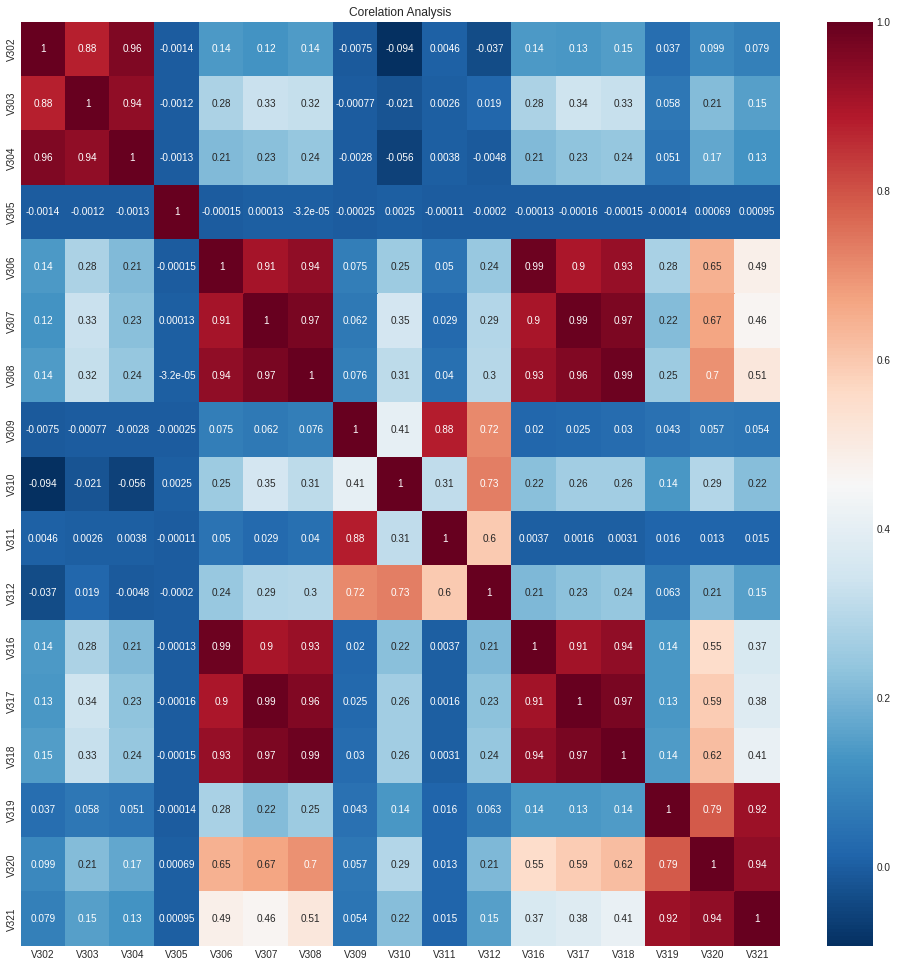

In [ ]:
cols = ['V302','V303','V304','V305','V306','V307','V308','V316','V317','V318','V309','V311','V310','V312','V319','V320','V321']

corelation_analysis(cols,title='Corelation Analysis',size=(17,17))

In [ ]:
pairs = [['V302','V303','V304'],['V305'],['V306','V307','V308','V316','V317','V318'],['V309','V311'],['V310','V312'],['V319','V320','V321']]

return_list = reduce_groups(pairs)
keep_cols.extend(return_list)
keep_cols

['V1',
 'V3',
 'V4',
 'V6',
 'V8',
 'V11',
 'V13',
 'V14',
 'V17',
 'V20',
 'V23',
 'V26',
 'V27',
 'V30',
 'V36',
 'V37',
 'V40',
 'V41',
 'V44',
 'V47',
 'V48',
 'V54',
 'V55',
 'V56',
 'V59',
 'V62',
 'V65',
 'V67',
 'V68',
 'V70',
 'V76',
 'V78',
 'V80',
 'V82',
 'V86',
 'V88',
 'V89',
 'V91',
 'V99',
 'V98',
 'V104',
 'V96',
 'V107',
 'V108',
 'V111',
 'V115',
 'V117',
 'V120',
 'V121',
 'V123',
 'V124',
 'V127',
 'V129',
 'V130',
 'V136',
 'V124',
 'V127',
 'V129',
 'V130',
 'V136',
 'V138',
 'V139',
 'V142',
 'V147',
 'V156',
 'V162',
 'V165',
 'V160',
 'V166',
 'V178',
 'V176',
 'V173',
 'V182',
 'V187',
 'V203',
 'V205',
 'V207',
 'V215',
 'V169',
 'V171',
 'V175',
 'V180',
 'V185',
 'V188',
 'V198',
 'V210',
 'V209',
 'V218',
 'V223',
 'V224',
 'V226',
 'V228',
 'V229',
 'V235',
 'V240',
 'V258',
 'V257',
 'V253',
 'V252',
 'V260',
 'V261',
 'V264',
 'V266',
 'V267',
 'V274',
 'V277',
 'V220',
 'V221',
 'V234',
 'V238',
 'V250',
 'V271',
 'V294',
 'V284',
 'V285',
 'V286',
 '

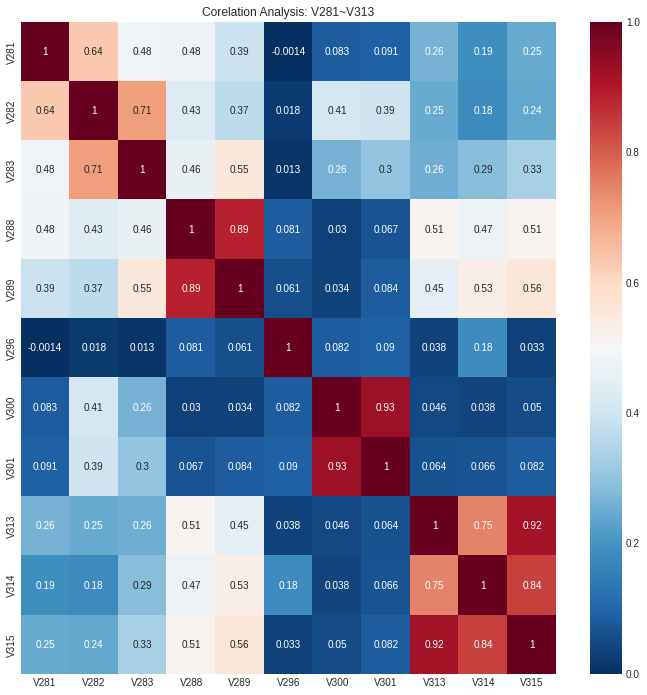

In [ ]:
cols = ['V296', 'V289', 'V288', 'V283', 'V282', 'V281', 'V300', 'V301', 'V313', 'V314', 'V315']

corelation_analysis(cols,title='Corelation Analysis: V281~V313',size=(12,12))

In [ ]:
pairs = [['V281'],['V282','V283'],['V288','V289'],['V296'],['V300','V301'],['V313','V314','V315']]

return_list = reduce_groups(pairs)
keep_cols.extend(return_list)
keep_cols

['V1',
 'V3',
 'V4',
 'V6',
 'V8',
 'V11',
 'V13',
 'V14',
 'V17',
 'V20',
 'V23',
 'V26',
 'V27',
 'V30',
 'V36',
 'V37',
 'V40',
 'V41',
 'V44',
 'V47',
 'V48',
 'V54',
 'V55',
 'V56',
 'V59',
 'V62',
 'V65',
 'V67',
 'V68',
 'V70',
 'V76',
 'V78',
 'V80',
 'V82',
 'V86',
 'V88',
 'V89',
 'V91',
 'V99',
 'V98',
 'V104',
 'V96',
 'V107',
 'V108',
 'V111',
 'V115',
 'V117',
 'V120',
 'V121',
 'V123',
 'V124',
 'V127',
 'V129',
 'V130',
 'V136',
 'V124',
 'V127',
 'V129',
 'V130',
 'V136',
 'V138',
 'V139',
 'V142',
 'V147',
 'V156',
 'V162',
 'V165',
 'V160',
 'V166',
 'V178',
 'V176',
 'V173',
 'V182',
 'V187',
 'V203',
 'V205',
 'V207',
 'V215',
 'V169',
 'V171',
 'V175',
 'V180',
 'V185',
 'V188',
 'V198',
 'V210',
 'V209',
 'V218',
 'V223',
 'V224',
 'V226',
 'V228',
 'V229',
 'V235',
 'V240',
 'V258',
 'V257',
 'V253',
 'V252',
 'V260',
 'V261',
 'V264',
 'V266',
 'V267',
 'V274',
 'V277',
 'V220',
 'V221',
 'V234',
 'V238',
 'V250',
 'V271',
 'V294',
 'V284',
 'V285',
 'V286',
 '

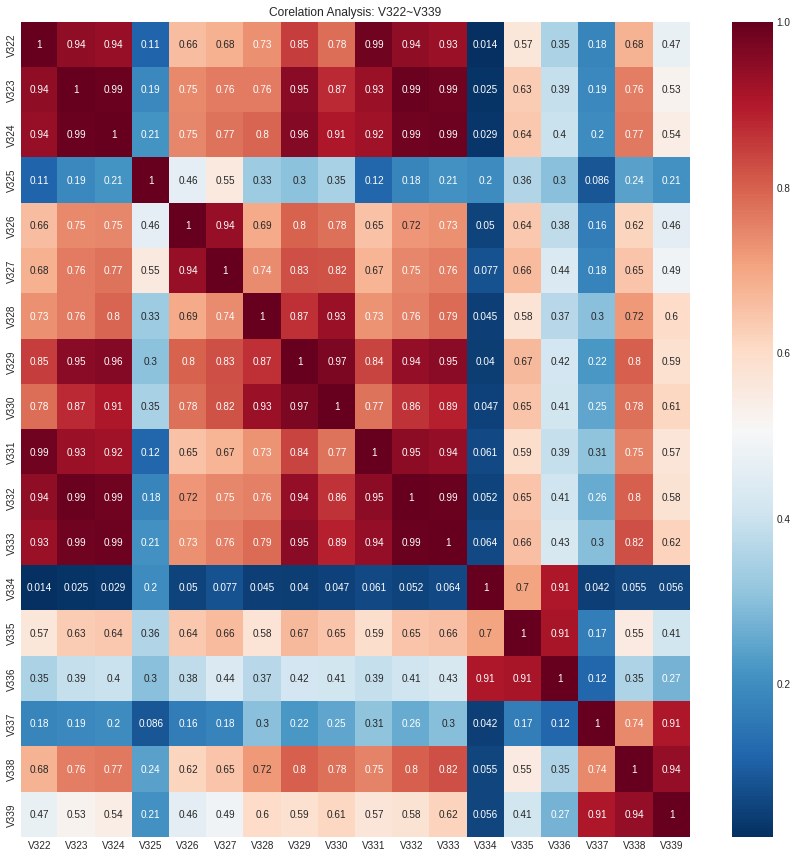

In [ ]:
cols = ['V337', 'V333', 'V336', 'V335', 'V334', 'V338', 'V339', 'V324', 'V332', 'V325', 'V330', 'V329', 'V328', 'V327', 'V326', 'V322', 'V323', 'V331']

corelation_analysis(cols,title='Corelation Analysis: V322~V339',size=(15,15))

In [ ]:
pairs = [['V322','V323','V324','V326','V327','V328','V329','V330','V331','V332','V333'],['V325'],
         ['V334','V335','V336'],['V337','V338','V339']]

return_list = reduce_groups(pairs)
keep_cols.extend(return_list)
keep_cols

['V1',
 'V3',
 'V4',
 'V6',
 'V8',
 'V11',
 'V13',
 'V14',
 'V17',
 'V20',
 'V23',
 'V26',
 'V27',
 'V30',
 'V36',
 'V37',
 'V40',
 'V41',
 'V44',
 'V47',
 'V48',
 'V54',
 'V55',
 'V56',
 'V59',
 'V62',
 'V65',
 'V67',
 'V68',
 'V70',
 'V76',
 'V78',
 'V80',
 'V82',
 'V86',
 'V88',
 'V89',
 'V91',
 'V99',
 'V98',
 'V104',
 'V96',
 'V107',
 'V108',
 'V111',
 'V115',
 'V117',
 'V120',
 'V121',
 'V123',
 'V124',
 'V127',
 'V129',
 'V130',
 'V136',
 'V124',
 'V127',
 'V129',
 'V130',
 'V136',
 'V138',
 'V139',
 'V142',
 'V147',
 'V156',
 'V162',
 'V165',
 'V160',
 'V166',
 'V178',
 'V176',
 'V173',
 'V182',
 'V187',
 'V203',
 'V205',
 'V207',
 'V215',
 'V169',
 'V171',
 'V175',
 'V180',
 'V185',
 'V188',
 'V198',
 'V210',
 'V209',
 'V218',
 'V223',
 'V224',
 'V226',
 'V228',
 'V229',
 'V235',
 'V240',
 'V258',
 'V257',
 'V253',
 'V252',
 'V260',
 'V261',
 'V264',
 'V266',
 'V267',
 'V274',
 'V277',
 'V220',
 'V221',
 'V234',
 'V238',
 'V250',
 'V271',
 'V294',
 'V284',
 'V285',
 'V286',
 '

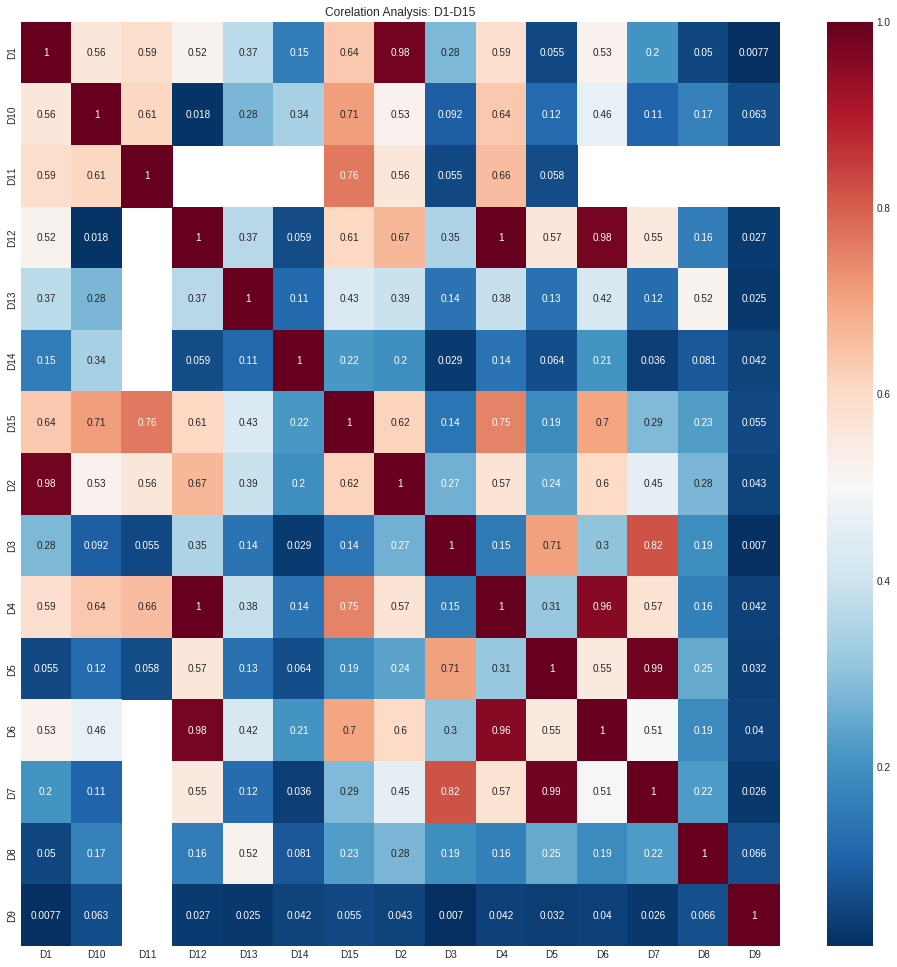

In [ ]:
cols = ['D'+str(x) for x in range(1,16)]

corelation_analysis(cols,title='Corelation Analysis: D1-D15',size=(17,17))

In [ ]:
pairs =[['D1','D2'],['D5','D7','D3'],['D6','D4','D12'],['D10'],['D11'],['D13'],['D14'],['D10','D11','D4','D6','D15']]

return_list = reduce_groups(pairs)
keep_cols.extend(return_list)
return_list

['D1', 'D5', 'D6', 'D10', 'D11', 'D13', 'D14', 'D15']

In [ ]:
keep_col = sorted(list(set(keep_cols)))
keep_col

['D1',
 'D10',
 'D11',
 'D13',
 'D14',
 'D15',
 'D5',
 'D6',
 'V1',
 'V104',
 'V107',
 'V108',
 'V11',
 'V111',
 'V115',
 'V117',
 'V120',
 'V121',
 'V123',
 'V124',
 'V127',
 'V129',
 'V13',
 'V130',
 'V136',
 'V138',
 'V139',
 'V14',
 'V142',
 'V147',
 'V156',
 'V160',
 'V162',
 'V165',
 'V166',
 'V169',
 'V17',
 'V171',
 'V173',
 'V175',
 'V176',
 'V178',
 'V180',
 'V182',
 'V185',
 'V187',
 'V188',
 'V198',
 'V20',
 'V203',
 'V205',
 'V207',
 'V209',
 'V210',
 'V215',
 'V218',
 'V220',
 'V221',
 'V223',
 'V224',
 'V226',
 'V228',
 'V229',
 'V23',
 'V234',
 'V235',
 'V238',
 'V240',
 'V250',
 'V252',
 'V253',
 'V257',
 'V258',
 'V26',
 'V260',
 'V261',
 'V264',
 'V266',
 'V267',
 'V27',
 'V271',
 'V274',
 'V277',
 'V281',
 'V283',
 'V284',
 'V285',
 'V286',
 'V289',
 'V291',
 'V294',
 'V296',
 'V297',
 'V3',
 'V30',
 'V301',
 'V303',
 'V305',
 'V307',
 'V309',
 'V310',
 'V314',
 'V320',
 'V325',
 'V332',
 'V335',
 'V338',
 'V36',
 'V37',
 'V4',
 'V40',
 'V41',
 'V44',
 'V47',
 'V48'

In [ ]:
train_data = pd.read_csv("/gdrive/My Drive/AIML/Project/train_combined.csv")
test_data = pd.read_csv("/gdrive/My Drive/AIML/Project/test_combined.csv")

In [ ]:
red_col = ['D1', 'D10', 'D11', 'D13', 'D14', 'D15', 'D5', 'D6', 'V1', 'V104', 'V107', 'V108', 'V11', 'V111', 'V115', 'V117', 'V120', 'V121', 'V123', 'V124', 'V127', 'V129', 'V13', 'V130', 'V136', 'V138', 'V139', 'V14', 'V142', 'V147', 'V156', 'V160', 'V162', 'V165', 'V166', 'V169', 'V17', 'V171', 'V173', 'V175', 'V176', 'V178', 'V180', 'V182', 'V185', 'V187', 'V188', 'V198', 'V20', 'V203', 'V205', 'V207', 'V209', 'V210', 'V215', 'V218', 'V220', 'V221', 'V223', 'V224', 'V226', 'V228', 'V229', 'V23', 'V234', 'V235', 'V238', 'V240', 'V250', 'V252', 'V253', 'V257', 'V258', 'V26', 'V260', 'V261', 'V264', 'V266', 'V267', 'V27', 'V271', 'V274', 'V277', 'V281', 'V283', 'V284', 'V285', 'V286', 'V289', 'V291', 'V294', 'V296', 'V297', 'V3', 'V30', 'V301', 'V303', 'V305', 'V307', 'V309', 'V310', 'V314', 'V320', 'V325', 'V332', 'V335', 'V338', 'V36', 'V37', 'V4', 'V40', 'V41', 'V44', 'V47', 'V48', 'V54', 'V55', 'V56', 'V59', 'V6', 'V62', 'V65', 'V67', 'V68', 'V70', 'V76', 'V78', 'V8', 'V80', 'V82', 'V86', 'V88', 'V89', 'V91', 'V96', 'V98', 'V99']
# droping v cols 
drop_v_cols = [col for col in train_data.columns if col[0] == 'V' and col not in red_col]
drop_d_cols = [col for col in train_data.columns if col[0] == 'D' and len(col) <= 3 and col not in red_col]

drop_cols = []
drop_cols.extend(drop_v_cols)
drop_cols.extend(drop_d_cols)

In [ ]:
print(f'dropping {len(drop_cols)} columns')
train_data = train_data.drop(columns=drop_cols)
test_data = test_data.drop(columns=drop_cols)

dropping 217 columns


In [ ]:
useful_cols = [col for col in train_data.columns if col not in ("isFraud","TransactionID_x", "TransactionID_y", "TransactionDT")]
print(len(useful_cols))

y_train = train_data['isFraud']
train_data = train_data.drop(columns='isFraud')
test_data.columns = [col for col in train_data.columns]
x_test = test_data[useful_cols].reset_index(drop=True)
x_train = train_data[useful_cols].reset_index(drop=True)

print(x_train.shape)
print(x_test.shape)
gc.collect()

214
(590540, 214)
(506691, 214)


0

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

label_encoder = LabelEncoder()
category_cols = x_train.select_dtypes(include=['object']).columns
type_map = {c: str for c in category_cols}
x_train[category_cols] = x_train[category_cols].astype(type_map, copy=False)
x_test[category_cols] = x_test[category_cols].astype(type_map, copy=False)

for col in category_cols:
    # label encode all cat columns
    dff = pd.concat([x_train[col],x_test[col]])
    dff,_ = pd.factorize(dff,sort=True)
    if dff.max()>32000: 
        print(col,'needs int32 datatype')
           
    x_train[col] = dff[:len(x_train)].astype('int16')
    x_test[col] = dff[len(x_train):].astype('int16')
del dff
#    label_encoder.fit(list(x_train[col].astype(str).values)+list(x_test[col].astype(str).values))
#    x_train[col] = label_encoder.transform(list(x_train.astype(str).values))
#    x_test[col] = label_encoder.transform(list(x_test.astype(str).values))



In [ ]:
scaler = StandardScaler()
x_train_scaler = scaler.fit_transform(x_train)
x_test_scaler = scaler.transform(x_test)

idx = int(x_train.shape[0] * 0.8)
print(idx)

472432


In [ ]:
cols = x_train.columns
print(f'fitting model on {len(cols)} columns')
x_train.fillna(-1,inplace=True)
x_test.fillna(-1,inplace=True)

idx_tr = x_train.index[:idx]  
idx_val = x_train.index[idx:]

clf = xgb.XGBClassifier( 
        n_estimators=2000,
        max_depth=12, 
        learning_rate=0.02, 
        subsample=0.8,
        colsample_bytree=0.4, 
        missing=-1, 
        eval_metric='auc'
          )
model = clf.fit(x_train.loc[idx_tr,cols], y_train[idx_tr], 
            eval_set=[(x_train.loc[idx_val,cols],y_train[idx_val])],
            verbose=50, early_stopping_rounds=100)

fitting model on 214 columns
[0]	validation_0-auc:0.818145
Will train until validation_0-auc hasn't improved in 100 rounds.
[50]	validation_0-auc:0.865189
[100]	validation_0-auc:0.876026
[150]	validation_0-auc:0.886032
[200]	validation_0-auc:0.895055
[250]	validation_0-auc:0.903416
[300]	validation_0-auc:0.909667
[350]	validation_0-auc:0.913072
[400]	validation_0-auc:0.915628
[450]	validation_0-auc:0.917167
[500]	validation_0-auc:0.918628
[550]	validation_0-auc:0.918514
[600]	validation_0-auc:0.918905
[650]	validation_0-auc:0.919079
[700]	validation_0-auc:0.919225
[750]	validation_0-auc:0.919023
Stopping. Best iteration:
[676]	validation_0-auc:0.919328



In [ ]:
def plot_confusion_matrix(y_actual, y_pred):
    #Get the confusion matrix, Precision & Re-call
    conf_matrix = confusion_matrix(y_actual, y_pred)
    recal_matrix =(((conf_matrix.T)/(conf_matrix.sum(axis=1))).T)        
    prec_matrix =(conf_matrix/conf_matrix.sum(axis=0))

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    conf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                        conf_matrix.flatten()/np.sum(conf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.figure(figsize=(20,4))
    plt.subplot(1, 3, 1)
    sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues')
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")

    plt.subplot(1, 3, 2)
    sns.heatmap(prec_matrix, annot=True, fmt='.3f', cmap='Blues')
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")

    plt.subplot(1, 3, 3)
    sns.heatmap(recal_matrix, annot=True, fmt='.3f', cmap='Blues')
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")

    plt.show()

Train ROC Score:  0.8728207950657312
Test ROC Score:  0.67684720543694
Test confusion_matrix


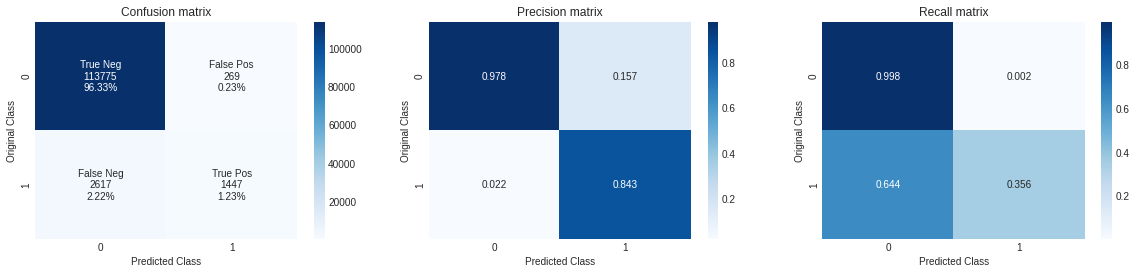

In [ ]:
y_train_pred = model.predict(x_train.iloc[idx_tr])
y_test_pred = model.predict(x_train.iloc[idx_val])

y_train_act = y_train.iloc[idx_tr]
y_test_act = y_train.iloc[idx_val]

ROC_score = roc_auc_score(y_train_act, y_train_pred)
print('Train ROC Score: ', ROC_score)

ROC_score = roc_auc_score(y_test_act, y_test_pred)
print('Test ROC Score: ', ROC_score)

print('Test confusion_matrix')
plot_confusion_matrix(y_test_act, y_test_pred)

In [ ]:
y_pred_test = model.predict_proba(x_test)[:,1]
submission = {}
submission.update(dict(zip(test_data['TransactionID_x'],y_pred_test)))
submission = pd.DataFrame.from_dict(submission, orient="index").reset_index()
submission.columns = ["TransactionID", "isFraud"]
submission.to_csv('/gdrive/My Drive/AIML/Project/submission.csv',index=False)
submission.head()

,TransactionID,isFraud
0,3663549,0.002308
1,3663550,0.002799
2,3663551,0.003152
3,3663552,0.002581
4,3663553,0.001970
